# Description

**Author:** Anna Luisa Hemshorn de Sánchez

**Affiliation:** (1) Department of Earth Sciences, VU Amsterdam, (2) Institute of Environmental Studies (IVM), VU Amsterdam, (3) Deltares

**Contact:** a.l.hemshorndesanchez@vu.nl

**Version:** V1

**Date:** Oct 20, 2025

**Description:** Data used in this notebook is obtained from: do Nascimento, T.V.M., Rudlang, J., Höge, M. et al. EStreams: An integrated dataset and catalogue of streamflow, hydro-climatic and landscape variables for Europe. _Sci Data_ 11, 879 (2024). https://doi.org/10.1038/s41597-024-03706-1

In this code we compute streamflow sensitivities to climate (P and T) at annual timescale:
* annual mean precipitation elasticities of annual mean, max and min streamflow
* annual max precipitation elasticities of annual max streamflow
* annual mean temperature sensitivities of annual mean, max and min streamflow

# Import packages

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.wkt import loads
from functools import reduce
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline, interp1d
from scipy.stats import spearmanr, gaussian_kde,linregress, theilslopes, pearsonr, t, skew, sem
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.offsetbox import AnchoredText
from matplotlib.transforms import Affine2D
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import matplotlib.ticker as ticker
import pyproj
from shapely.geometry import Point
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.transforms import Bbox
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize, LinearSegmentedColormap, to_rgb
from matplotlib.dates import DateFormatter
from matplotlib.lines import Line2D
from cmcrameri import cm # to be cited
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import RANSACRegressor, LinearRegression, TheilSenRegressor #, HuberRegressor
from sklearn.utils import resample
from sklearn.metrics import r2_score
import colorcet as cc
import sys
import gc

# Define file paths

In [2]:
# Get main directories
nb_dir = Path.cwd()
parent_dir = nb_dir.parent.parent.parent.parent
fp = parent_dir / "Data/Europe/estreams/EStreams_v1.3/"

# Input directories and filepaths
fp_gauges = fp / "streamflow_gauges/estreams_gauging_stations.csv"
fp_met = fp / "meteorology/" # contains: estreams_meteorology_{basin_id}.csv
fp_hydsig = fp / "hydroclimatic_signatures/estreams_hydrometeo_signatures.csv"
fp_shp_gau = fp / "shapefiles/estreams_gauging_stations.shp"
fp_shp_cat = fp / "shapefiles/estreams_catchments.shp"
fp_attr_stat = fp / "attributes/static_attributes/" # contains: estreams_{attribute_type}_attributes.csv
fp_attr_temp = fp / "attributes/temporal_attributes/" # contains: estreams_{attribute_type}_[time_scale].csv
fp_qidx_mon = fp / "streamflow_indices/monthly/" # contains: monthly_streamflow_{index}.csv
fp_qidx_season = fp / "streamflow_indices/seasonal/" # contains: seasonal_streamflow_{index}.csv
fp_qidx_week = fp / "streamflow_indices/weekly/" # contains: weekly_streamflow_{index}.csv
fp_qidx_year = fp / "streamflow_indices/yearly/" # contains: yearly_streamflow_{index}.csv

# Output directories
fp_gh = parent_dir / "Code/GitHub/streamflow_sensitivity_europe/"
fp_processed = fp_gh / "data/processed/" 
fp_tempstats = fp_processed / "02_temporal_stats/" 
fp_out_hyr = fp_tempstats / "02_hyearly/"
fp_figures = fp_gh / "figures/" 

# Read data

In [3]:
basin_id_sel = pd.read_csv(fp_processed/"01_selection/basin_id_sel.csv", index_col=0)['basin_id']
print('Amount of gauges: ', len(basin_id_sel))

# Load the Europe boundaries (Natural Earth dataset)
europe = gpd.read_file(parent_dir/"Data/Admin/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp") #CNTR_BN_01M_2020_3035.shp/CNTR_BN_01M_2020_3035.shp')#
europe = europe[(europe['CONTINENT'].str.contains('Europe', case=False, na=False)) |
                ((europe.geometry.bounds['minx'] >= -10) &     
                 (europe.geometry.bounds['maxx'] <= 50) &
                 (europe.geometry.bounds['miny'] >= 30) & 
                 (europe.geometry.bounds['maxy'] <= 70))] #europe = europe.cx[-10:50, 30:70] #europe = europe[europe['CONTINENT'] == 'Europe']

# Overview DataFrame that is used to store all new results into
result_df = pd.read_csv(fp_processed/"01_selection/gauges_metadata.csv", index_col='basin_id')
result_df['geometry'] = result_df['wkt_geometry'].apply(loads)
result_gdf = gpd.GeoDataFrame(result_df, geometry='geometry')
result_gdf.set_crs("EPSG:4326", inplace=True)
result_gdf = result_gdf.sort_index()

Amount of gauges:  8307


In [4]:
# Define the annual split for the entire script:
MON_str = 'OCT' #'SEP'

In [5]:
# Read absolute hyearly Q and T dataframes
Qmean_hyr = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Qmean.csv", index_col=0, parse_dates=[0])[basin_id_sel]
Q1dmax_hyr = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q1dmax.csv", index_col=0, parse_dates=[0])[basin_id_sel]
Q1dmin_hyr = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q1dmin.csv", index_col=0, parse_dates=[0])[basin_id_sel]
Q7dmin_hyr = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q7dmin.csv", index_col=0, parse_dates=[0])[basin_id_sel]

Tmean_hyr = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Tmean.csv", index_col=0, parse_dates=[0])[basin_id_sel]

In [6]:
## Read normalized hyearly dataframes

# Q and P ------------------------------------------------------------------------------------------------------
Qmean_hyr_norm_QmeanPmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Qmean_normalized_QmeanPmean.csv",index_col=0, parse_dates=[0])#[basin_id_sel]
Pmean_hyr_norm_QmeanPmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Pmean_normalized_QmeanPmean.csv",index_col=0, parse_dates=[0])#[basin_id_sel]

Q1dmax_hyr_norm_Q1dmaxPmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q1dmax_normalized_Q1dmaxPmean.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]
Pmean_hyr_norm_Q1dmaxPmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Pmean_normalized_Q1dmaxPmean.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]

Q1dmax_hyr_norm_Q1dmaxPmax = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q1dmax_normalized_Q1dmaxPmax.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]
Pmax_hyr_norm_Q1dmaxPmax = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Pmax_normalized_Q1dmaxPmax.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]

Q1dmin_hyr_norm_Q1dminPmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q1dmin_normalized_Q1dminPmean.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]
Pmean_hyr_norm_Q1dminPmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Pmean_normalized_Q1dminPmean.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]

Q7dmin_hyr_norm_Q7dminPmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q7dmin_normalized_Q7dminPmean.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]
Pmean_hyr_norm_Q7dminPmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Pmean_normalized_Q7dminPmean.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]

# Q and Ep ------------------------------------------------------------------------------------------------------
Qmean_hyr_norm_QmeanEpmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Qmean_normalized_QmeanEpmean.csv",index_col=0, parse_dates=[0])#[basin_id_sel]
Epmean_hyr_norm_QmeanEpmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Epmean_normalized_QmeanEpmean.csv",index_col=0, parse_dates=[0])#[basin_id_sel]

Q1dmax_hyr_norm_Q1dmaxEpmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q1dmax_normalized_Q1dmaxEpmean.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]
Epmean_hyr_norm_Q1dmaxEpmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Epmean_normalized_Q1dmaxEpmean.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]

Q1dmin_hyr_norm_Q1dminEpmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q1dmin_normalized_Q1dminEpmean.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]
Epmean_hyr_norm_Q1dminEpmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Epmean_normalized_Q1dminEpmean.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]

Q7dmin_hyr_norm_Q7dminEpmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q7dmin_normalized_Q7dminEpmean.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]
Epmean_hyr_norm_Q7dminEpmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Epmean_normalized_Q7dminEpmean.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]

# Q and T ------------------------------------------------------------------------------------------------------
Qmean_hyr_norm_QmeanTmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Qmean_normalized_QmeanTmean.csv",index_col=0, parse_dates=[0])#[basin_id_sel]
Tmean_hyr_QmeanTmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Tmean_QmeanTmean.csv",index_col=0, parse_dates=[0])#[basin_id_sel]

Q1dmax_hyr_norm_Q1dmaxTmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q1dmax_normalized_Q1dmaxTmean.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]
Tmean_hyr_Q1dmaxTmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Tmean_Q1dmaxTmean.csv",index_col=0, parse_dates=[0])#[basin_id_sel]

Q1dmin_hyr_norm_Q1dminTmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q1dmin_normalized_Q1dminTmean.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]
Tmean_hyr_Q1dminTmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Tmean_Q1dminTmean.csv",index_col=0, parse_dates=[0])#[basin_id_sel]

Q7dmin_hyr_norm_Q7dminTmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Q7dmin_normalized_Q7dminTmean.csv",index_col=0, parse_dates=[0]) #[basin_id_sel]
Tmean_hyr_Q7dminTmean = pd.read_csv(fp_out_hyr/f"hyearly_A-{MON_str}_Tmean_Q7dminTmean.csv",index_col=0, parse_dates=[0])#[basin_id_sel]

# Linear Regression

How sensitive is annual mean  ($Q_{mean}$)  and extreme flow ($Q_{max}$ and $Q_{min}$) to changes in annual $P_{mean}$ and to changes in annual $T_{mean}$? Keep in mind that T is not used in its normalized form but with absolute values and the unit degC.

## Multiple linear regression

We apply search for values for $\varepsilon_P$ and $\zeta_T$ that reduce the minimum squared error:

$Q_{norm} = \alpha_0 + \varepsilon_P * P_{norm} + \zeta_T * T_{abs} + u$

Where:

* $\alpha_0$: intercept
* $\varepsilon_P$: coefficient for precipitation
* $\zeta_T$: coefficient for temperature 
* u: residual error

In [7]:
%%time
def multiple_linear_regression(Q, P, T, 
                      min_data_pts=15, ci=0.90):
    """
    Conducts multiple linear regression for three cases: (1) using P and T timeseries, (2) using P timeseries only 
    and (3) using T timeseries only. For (1) it returns the coefficients for P and T, which are the streamflow 
    elasticity and the temperature sensitivity, the intercept and the p values. For all three cases it returns the
    R2 values.
    
    Parameters:
    - Q (pandas.DataFrame): DataFrame of the normalised streamflow timeseries.
    - P (pandas.DataFrame): DataFrame of the normalised precipitation timeseries.
    - T (pandas.DataFrame): DataFrame of the absolute temperature timeseries.
    - min_data_pts (int): Minimum amount of years with valid values.
    - ci (float): confidence interval.
    
    Returns:
    - output (pandas.DataFrame): DataFrame with location index, elasticity, sensitivity, intercept, p-values and R2 values.
    """
    
    output = pd.DataFrame(columns=['basin_id', 'P_elas', 'T_sens', 'intercept', 
                                   #'P_lower_ci', 'P_upper_ci',
                                   #'T_lower_ci', 'T_upper_ci', 
                                   'P_pval', 'T_pval',
                                   'r2', 'r2_P', 'r2_T'])
    output['basin_id'] = Q.columns

    for basin in Q.columns: 
        
        mask = Q[basin].notna() & P[basin].notna() & T[basin].notna() #this ignores that one df has its datetime index in oct and the other one in dec
        y_Q_bsn = Q[basin][mask].values
        x_P_bsn = P[basin][mask].values
        x_T_bsn = T[basin][mask].values

        if len(y_Q_bsn) >= min_data_pts:
            
            # Full model: Q ~ P + T
            x_bsn = sm.add_constant(np.column_stack((x_P_bsn, x_T_bsn))) # predictors: shape (70, 2) adds intercept term: shape (70, 3)
            #y_bsn = y_Q_bsn                              # response: shape (70,)
            model = sm.OLS(y_Q_bsn, x_bsn).fit(cov_type='HC3') # OLS model not robust to outliers but estimation of SEs is adjusted (HC3 is often recommended for small samples or when outliers are a concern.))
            
            # P only: Q ~ P
            x_P = sm.add_constant(x_P_bsn)
            model_P = sm.OLS(y_Q_bsn, x_P).fit(cov_type='HC3')
            
            # T only: Q ~ T
            x_T = sm.add_constant(x_T_bsn)
            model_T = sm.OLS(y_Q_bsn, x_T).fit(cov_type='HC3')
            
            output.loc[output['basin_id'] == basin, ['intercept', 'P_elas', 'T_sens']] = model.params 
            output.loc[output['basin_id'] == basin, ['P_pval', 'T_pval']] = model.pvalues[1:3]
            output.loc[output['basin_id'] == basin, 'r2'] = model.rsquared  
            output.loc[output['basin_id'] == basin, 'r2_P'] = model_P.rsquared  
            output.loc[output['basin_id'] == basin, 'r2_T'] = model_T.rsquared  
            #ci_bsn = model.conf_int(alpha=1-ci) # alpha=0.1 means 90% confidence interval
            #output.loc[output['basin_id'] == basin, ['P_lower_ci', 'P_upper_ci']] = ci_bsn[1]
            #output.loc[output['basin_id'] == basin, ['T_lower_ci', 'T_upper_ci']] = ci_bsn[2]
            
        else:
            output.loc[output['basin_id'] == basin, ['P_elas', 'T_sens', 'intercept', 
                                                   #'P_lower_ci', 'P_upper_ci',
                                                   #'T_lower_ci', 'T_upper_ci', 
                                                     'P_pval', 'T_pval',
                                                     'r2', 'r2_P', 'r2_T']] = np.nan
    output.set_index('basin_id', inplace=True)
    return output

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 1.91 µs


In [8]:
%%time
QmeanPmeanTmean_mlr = multiple_linear_regression(Q=Qmean_hyr_norm_QmeanPmean, 
                                                 P=Pmean_hyr_norm_QmeanPmean, 
                                                 T=Tmean_hyr, 
                                                 min_data_pts=15, ci=0.90)
QmaxPmeanTmean_mlr = multiple_linear_regression(Q=Q1dmax_hyr_norm_Q1dmaxPmean, 
                                                P=Pmean_hyr_norm_Q1dmaxPmean, 
                                                T=Tmean_hyr, 
                                                min_data_pts=15, ci=0.90)
QminPmeanTmean_mlr = multiple_linear_regression(Q=Q7dmin_hyr_norm_Q7dminPmean, 
                                                P=Pmean_hyr_norm_Q7dminPmean, 
                                                T=Tmean_hyr, 
                                                min_data_pts=15, ci=0.90)
QmaxPmaxTmean_mlr = multiple_linear_regression(Q=Q1dmax_hyr_norm_Q1dmaxPmax, 
                                               P=Pmax_hyr_norm_Q1dmaxPmax,
                                               T=Tmean_hyr, 
                                               min_data_pts=15, ci=0.90)

CPU times: user 1min 28s, sys: 105 ms, total: 1min 28s
Wall time: 1min 29s


In [9]:
%%time
result_gdf_mlr = result_gdf.copy()
for df, combi_str in zip([QmeanPmeanTmean_mlr, QmaxPmeanTmean_mlr, QminPmeanTmean_mlr, QmaxPmaxTmean_mlr],
                          ['QmeanPmean', 'QmaxPmean', 'QminPmean', 'QmaxPmax']):
    for col in df.columns: #['P_elas', 'T_sens', 'intercept', 'P_pval', 'T_pval', 'r2']:
        df = df.rename(columns={col: str(combi_str+'Tmean_A-'+col)})
        result_gdf_mlr = result_gdf_mlr.merge(df[[str(combi_str+'Tmean_A-'+col)]], on='basin_id', how='inner')
        result_gdf_mlr[str(combi_str+'Tmean_A-'+col)] = result_gdf_mlr[str(combi_str+'Tmean_A-'+col)].apply(pd.to_numeric, errors='coerce')
result_gdf_mlr.to_csv(fp_processed/"03_sensitivities/01_hyearly/hyearly_PelasTsens_mlr_summary.csv")

CPU times: user 452 ms, sys: 12.7 ms, total: 465 ms
Wall time: 469 ms


In [10]:
print("Statistics of streamflow elasticities to precipitation: \n")

for elas in ['QmeanPmeanTmean_A-P_elas', 'QmaxPmeanTmean_A-P_elas', 'QminPmeanTmean_A-P_elas']:
    elas_mean = result_gdf_mlr[str(elas)].mean()
    elas_median = result_gdf_mlr[str(elas)].median()
    elas_std = result_gdf_mlr[str(elas)].std()
    print(f"{elas} \nMean: {elas_mean:.3f} \nMedian: {elas_median:.3f}\nStd: {elas_std:.3f}")

print("\nStatistics of streamflow sensitivities to temperature: \n")
for sens in ['QmeanPmeanTmean_A-T_sens', 'QmaxPmeanTmean_A-T_sens', 'QminPmeanTmean_A-T_sens']:
    sens_mean = result_gdf_mlr[str(sens)].mean()
    sens_median = result_gdf_mlr[str(sens)].median()
    sens_std = result_gdf_mlr[str(sens)].std()
    print(f"{sens} \nMean: {sens_mean:.3f} \nMedian: {sens_median:.3f}\nStd: {sens_std:.3f}\n")

Statistics of streamflow elasticities to precipitation: 

QmeanPmeanTmean_A-P_elas 
Mean: 1.200 
Median: 1.216
Std: 0.531
QmaxPmeanTmean_A-P_elas 
Mean: 1.380 
Median: 1.270
Std: 0.951
QminPmeanTmean_A-P_elas 
Mean: 1.008 
Median: 0.901
Std: 0.952

Statistics of streamflow sensitivities to temperature: 

QmeanPmeanTmean_A-T_sens 
Mean: -0.031 
Median: -0.024
Std: 0.118

QmaxPmeanTmean_A-T_sens 
Mean: -0.045 
Median: -0.041
Std: 0.184

QminPmeanTmean_A-T_sens 
Mean: -0.063 
Median: -0.054
Std: 0.271



### $R^2$ plots

In [11]:
print("Median R^2 values considering P and T, only P or only T:")
for model in ['QmeanPmeanTmean', 'QmaxPmeanTmean', 'QminPmeanTmean']:
    print(f"\n{model}")
    for r2 in ['r2', 'r2_P', 'r2_T']:
        mod_r2 = result_gdf_mlr[str(model+'_A-'+r2)].median()
        print(f"{r2}: {mod_r2:.2f}.")

Median R^2 values considering P and T, only P or only T:

QmeanPmeanTmean
r2: 0.51.
r2_P: 0.46.
r2_T: 0.03.

QmaxPmeanTmean
r2: 0.24.
r2_P: 0.19.
r2_T: 0.02.

QminPmeanTmean
r2: 0.24.
r2_P: 0.16.
r2_T: 0.04.


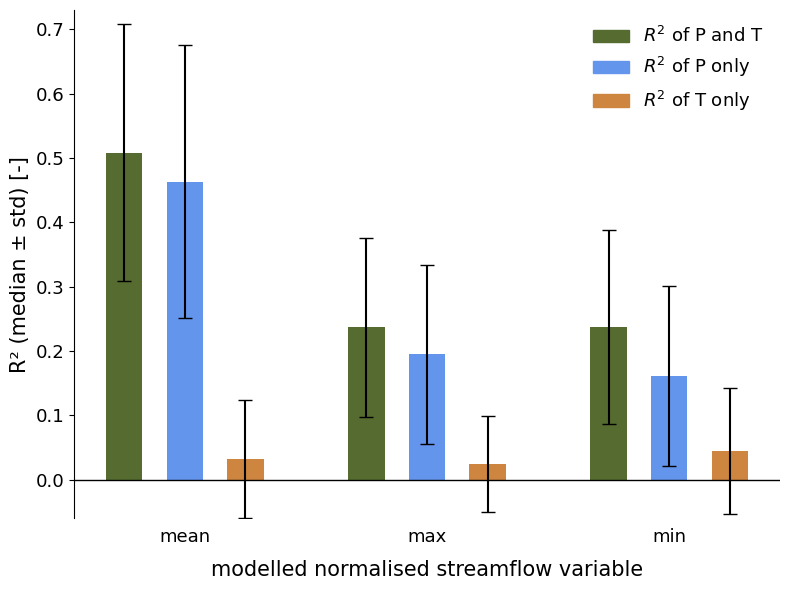

In [12]:
ft = 15

# Extract relevant columns 
r2_cols = [col for col in result_gdf_mlr.columns if col.endswith(('A-r2', 'A-r2_P', 'A-r2_T'))]

# Melt to long format 
df_long = result_gdf_mlr[r2_cols].melt(var_name='metric', value_name='r2_value')

# Parse metric into model_type and r2_type
df_long[['model_type', 'r2_type']] = df_long['metric'].str.extract(r'(QmeanPmeanTmean|QmaxPmeanTmean|QminPmeanTmean)\_A-(r2(?:_P|_T)?)')

# Group to compute median and std per group
summary_df = df_long.groupby(['model_type', 'r2_type']).agg(
    median=('r2_value', 'median'),
    std=('r2_value', 'std')
).reset_index()

# Sort the data for plotting order
sort_order = pd.MultiIndex.from_product(
    [['QmeanPmeanTmean', 'QmaxPmeanTmean', 'QminPmeanTmean'], ['r2', 'r2_P', 'r2_T']],
    names=['model_type', 'r2_type'])
summary_df.set_index(['model_type', 'r2_type'], inplace=True)
summary_df = summary_df.reindex(sort_order).reset_index()

# Plot 
plt.figure(figsize=(8, 6))
colors = {'r2': 'darkolivegreen', 'r2_P': 'cornflowerblue', 'r2_T': 'peru'}

# Dictionaries for label replacements
model_dict = {'QmeanPmeanTmean': 'mean', 'QmaxPmeanTmean': 'max', 'QminPmeanTmean': 'min'}
r2_dict = {'r2': '$R^2$ of P and T', 'r2_P': '$R^2$ of P only', 'r2_T': '$R^2$ of T only'}

# Define positions with spacing between model groups
group_spacing = 1
bar_width = 0.6
x = []
labels = []
for i, model_type in enumerate(['QmeanPmeanTmean', 'QmaxPmeanTmean', 'QminPmeanTmean']):
    base = i * (3 + group_spacing)
    x += [base + j for j in range(3)]
    labels.append(model_dict[model_type])

# Bar positions
bar_colors = summary_df['r2_type'].map(colors)

plt.bar(x, summary_df['median'], yerr=summary_df['std'],
    capsize=5, color=bar_colors, width=bar_width)

# Draw horizontal line at R² = 0
plt.axhline(0, color='black', linewidth=1)

# Remove top and right spines
sns.despine(top=True, right=True, left=False, bottom=True)
plt.tick_params(axis='x', which='both', bottom=False)

# Simplify x-axis labels: one per group
group_centers = [np.mean(x[i*3:(i+1)*3]) for i in range(3)]
plt.xticks(ticks=group_centers, labels=labels, fontsize=ft-2)
plt.yticks(fontsize=ft-2)

# Aesthetics
plt.ylabel('R² (median ± std) [-]', fontsize=ft)
plt.xlabel('modelled normalised streamflow variable', fontsize=ft, labelpad=10)
plt.ylim(-0.06, 0.73)
legend_handles = [plt.Rectangle((0,0),1,1,color=colors[r2]) for r2 in colors]
plt.legend(legend_handles, [r2_dict[key] for key in r2_dict], #colors.keys(), 
           title=None, frameon=False, fontsize=ft-2)
plt.tight_layout()
plt.savefig(fp_figures/"03_sensitivities/01_hyearly/r2/R2_summary_plot.png", dpi=300, bbox_inches='tight')
plt.savefig(fp_figures/"03_sensitivities/01_hyearly/r2/R2_summary_plot.pdf", bbox_inches='tight')
plt.show()

### Kernel density plots

For the mlr method the $R^2$ corresponds to the combined value of P and T.

In [13]:
ft = 18

def get_n_colors_from_cmap(cmap, n):
    """Extracts n evenly spaced colors from a given colormap."""
    return [cmap(i / (n - 1)) for i in range(n)]

# Extract 8 colors from the Batlow colormap
density_colors = get_n_colors_from_cmap(cmap=cc.m_CET_L20_r, n=12) #cm.lipari_r #cm.batlow_r
metric_colors = get_n_colors_from_cmap(cmap=cm.managua_r, n=10)
color_mean = metric_colors[5]
color_max = metric_colors[2] 
color_min = metric_colors[8] 
color_maxPmax = metric_colors[0] 
kernel_colors= [color_mean, color_max, color_min]

linestyles = ['-', '--', ':']


def vline_for_kde_array(elas, col_str, x_vals, y_vals):
    """Adds vertical line at the median of elas to a kernel density plot."""
    x_median = elas[col_str].median()

    # Interpolate y-values from KDE to get y at median
    kde_interp = interp1d(x_vals, y_vals, kind='linear', fill_value="extrapolate")
    y_median = kde_interp(x_median)
    
    return x_median, y_median

def vline_for_kde_r2(elas, col_str, kde):
    x_median = elas[col_str].median()
    
    # Extract the KDE curve data (x and y values)
    kde_line = kde.get_lines()[-1]  # Get the last added line (most recent KDE)
    x_data, y_data = kde_line.get_xdata(), kde_line.get_ydata()
    
    # Interpolate the KDE curve to find y at the median x
    kde_interp = interp1d(x_data, y_data, kind='linear', fill_value="extrapolate")
    y_median = kde_interp(x_median)
    
    return x_median, y_median


def plot_kde_var(gdf, t_scale, method, met_type, p_type, fig_let, legend_x, legend_y, ylim, fname, plt_r2=False):
    """
    Plot kernel density plots of streamflow elasticities to P or streamflow sensitivities to T. Optionally, 
    an inset plot showing the distribution of R2 values can be added.
    
    Parameters:
    - gdf (geopandas.GeoDataFrame): A GeoDataFrame containing the elasticity/sensitivity values for all locations.
    - t_scale (str): Timescale, e.g. 'A', 'hfs', 'lfs'.
    - method (str): Linear regression method, e.g. 'mlr' or 'hlr'.
    - met_type (str): Type of meteorological input, e.g. 'P' or 'T'.
    - p_type (str): Type of precipitation considered, e.g. 'Pmean' or 'Pmax'.
    - fig_let (str): Letter for the figure title, e.g. 'a', 'b', 'c'.
    - legend_x (float): Horizontal position of the legend.
    - legend_y (float): Vertical position of the legend.
    - ylim (float): Limit of the y axis.
    - fname (str): Filename to save the kde plot.
    - plt_r2=False (bool): A boolean flag to enable inset plot with R2 distribution.
    
    Returns:
    - None
    """
    
    
    t_dict = {'A': 'annual', 'hfs': 'cold season', 'lfs': 'warm season'}
    
    plot_settings = {
    'P': {
        'title': fr'$\bf{{{fig_let}}}$ kernel densities of elasticities to'+'\n' + fr'{t_dict[t_scale]} precipitation',  
        'xlim': (-1, 4),  
        'ylim': (0,ylim),
        'met_long': 'P_elas', 
        'letter': '\epsilon',
        'xlabel': 'streamflow elasticity to precipitation (${{\epsilon}^Q_P}$) [-]',
        'minor_ticks': np.arange(-0.5, 4, 0.5)},
    'T': {
        'title': fr'$\bf{{{fig_let}}}$ kernel densities of sensitivities'+'\n'+ fr'{t_dict[t_scale]} temperature',
        'xlim': (-0.6,0.6),
        'ylim': (0,ylim),
        'met_long': 'T_sens', 
        'letter': '\zeta',
        'xlabel': 'streamflow sensitivity of temperature (${{\zeta}^Q_T}$) [$°C^{-1}$]',
        'minor_ticks': np.arange(-0.6, 0.6, 0.1)}}
    sets = plot_settings[met_type]
    xlim = sets['xlim']
    ylim = sets['ylim']
    title = sets['title']
    
    p_type_setting = {
    'Pmean':{'rows':1,
             'Q_strs': ['Qmean', 'Qmax', 'Qmin'],
             'colors': kernel_colors,
             'linestyles': ['-','--',':'],
             'y_pad': 0.12,
             #'cond':[0,1,2]
            },
    'Pmax':{'rows':1,
           'Q_strs': ['Qmax'],
            'colors': [color_max], #
            'linestyles': ['-'],
            'y_pad': 0.05,
             #'cond':[0,0,0]
           }}
    p_sets = p_type_setting[p_type]
    #cond = p_sets['cond']
    
    vline_color = 'lightgray'
    vtext_color = 'gray'
    
    # Set up the plot
    fig, ax = plt.subplots(1,1, figsize=(8.5, 12), dpi=300) #, sharey=False)
    fig.patch.set_alpha(0)
    
    if plt_r2 ==True: # in case we want to add the R2 plot 
        inset_ax = fig.add_axes([legend_x+0.05, legend_y-0.26, 0.27, 0.12])
        inset_ax.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
        sns.despine(top=True, right=True, left=True)
        inset_ax.set_xlabel('$R^2$ [-]', fontsize=ft-1)
        inset_ax.set_ylabel('density [-]', fontsize=ft-1) #Kernel Density', fontsize=ft+2)
        #inset_ax.set_title(r'$\bf{b}$ kernel densities of $R^2$', fontsize=ft,loc='left') #'R² Values for Different Annual Q Metrics', fontsize=ft+3)
        inset_ax.set_xticks(np.arange(0, 1.2, 0.5)) # Major ticks
        inset_ax.set_xticks(np.arange(-0.2, 1.1, 0.1), minor=True) # Minor ticks
        inset_ax.tick_params(axis='x', labelsize=ft-2)
        inset_ax.set_xlim(-0.2, 1)
        inset_ax.tick_params(axis='y', left=False, labelleft=False)
        inset_ax.patch.set_alpha(0)
        title = str(title + ' and $R^2$ values')
    
    ax.text(0.01, 0.97, title, fontsize=ft+3, transform=ax.transAxes, ha='left', va='top')
    ax.set_xlabel(sets['xlabel'], fontsize=ft+2)
    ax.tick_params(axis='x', labelsize=ft-2)
    ax.tick_params(axis='y', labelsize=ft-2)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.spines[['top', 'right']].set_visible(False)
    ax.vlines(x=0, ymin=0, ymax=ylim[1]*0.9, linestyle='--', color=vline_color, zorder=0)
    ax.vlines(x=-1, ymin=0, ymax=ylim[1]*0.9, linestyle='--', color=vline_color, zorder=0)
    ax.vlines(x=1, ymin=0, ymax=ylim[1]*0.9, linestyle='--', color=vline_color, zorder=0)
        
    handles =[]
    labels = []
    
    met_dict = {'P': 'P_elas', 'T': 'T_sens'}
    
    for i, (Q_str, color, linestyle) in enumerate(zip(p_sets['Q_strs'], p_sets['colors'], p_sets['linestyles'])):
        
        if method == 'mlr':
            col_pref = str(Q_str+p_type+'Tmean_'+t_scale+'-')
        elif method == 'hlr': # !! This still neds to be adapted to be able to work with seasonal data as well!
            if met_type == 'P':
                col_pref = str(Q_str+p_type+'_'+t_scale+'-') 
            elif met_type == 'T':
                col_pref = str(Q_str+p_type+'_Tmean_'+t_scale+'-') 
        col_name = str(col_pref+met_dict[met_type])
        col_r2 = str(col_pref+'r2')
        
        x_all = pd.to_numeric(gdf[col_name], errors='coerce').dropna().squeeze()
        
        # KDEs (scaled by relative frequency)
        kde_all = gaussian_kde(x_all, bw_method=0.05) #bw_method='scott')

        # Shared x-axis for evaluation
        x_vals = np.linspace(x_all.min(), x_all.max(), 200)

        density_all = kde_all(x_vals)
        
        # Plot kernel density for each DataFrame, with labels for the legend
        line, = ax.plot(x_vals, density_all, color=color, linestyle=linestyle, linewidth=3.5, zorder=i+3) #density_sig, ###label=str('sig $'+letter+'^{{Q_{{{'+Q_str[0:]+'}}}}}_{{'+met+'_{{{mean}}}}}$'), 

        # Add vertical line at the median from x-axis to density curve
        x_median_elas, y_median_elas = vline_for_kde_array(elas=gdf, col_str=col_name, x_vals=x_vals, y_vals=density_all) #x_median_elas, y_median_elas = vline_for_kde(elas=df_sig, col_str=str(Q_str+'PmeanTmean_'+met_dict[met]), kde=kde_elas)
        ax.vlines(x_median_elas, ymin=0, ymax=y_median_elas, color=color, linestyle='-', linewidth=2, zorder=i+3)   
        
        if plt_r2 ==True:
            # Plot kernel density for each DataFrame, with labels for the legend
            kde_r2 = sns.kdeplot(gdf[col_r2].squeeze(), ax=inset_ax, 
                                bw_adjust=0.4, color=color, linestyle=linestyle, linewidth=1.5) 
            x_median_r2, y_median_r2 = vline_for_kde_r2(elas=gdf, col_str=col_r2, kde=kde_r2) 
            inset_ax.vlines(x_median_r2, ymin=0, ymax=y_median_r2, color=color, linestyle='-', linewidth=1)
        
        # Legend entries
        handles.append(line)
        labels.append(str('$'+sets['letter']+'^{{Q_{{{'+Q_str[1:]+'}}}}}_{{'+met_type+'_{{{'+p_type[1:]+'}}}}}$'))
    
    
    ax.legend(handles=handles, labels=labels, ncol=1,
              bbox_to_anchor=(legend_x, legend_y), loc='center left',
              fontsize=ft+6, frameon=False)

    ax.set_ylabel('density [-]', fontsize=ft+2, labelpad=9) 
    ax.set_xticks(sets['minor_ticks'], minor=True)
    
    if met_type == 'P':
        ax.set_xticks(np.arange(-1, 4.1, 1))
        # Add text boxes in the middle of each background color
        ax.text(0.1, legend_y + 0.163, 'reversed\ndampened', color=vtext_color, fontsize=ft-1, ha='center', transform=ax.transAxes)
        ax.text(0.3, legend_y + 0.19, 'dampened', color=vtext_color, fontsize=ft-1, ha='center', transform=ax.transAxes)
        ax.text(0.72, legend_y + 0.19, 'amplified', color=vtext_color, fontsize=ft-1, ha='center', transform=ax.transAxes)
    elif met_type == 'T':
        ax.text(0.24, legend_y + 0.19, 'negative', color=vtext_color, fontsize=ft-1, ha='center', transform=ax.transAxes)
        ax.text(0.75, legend_y + 0.19, 'positive', color=vtext_color, fontsize=ft-1, ha='center', transform=ax.transAxes)
    
    fig.savefig(fp_figures/f"03_sensitivities/{fname}.png", dpi=300, bbox_inches='tight')
    fig.savefig(fp_figures/f"03_sensitivities/{fname}.pdf", bbox_inches='tight')
    plt.close()
    return

In [14]:
def split_by_signifcance(method, Q_str, met_type, p_type, t_scale, gdf):
    """
    Splits the input geopandas DataFrame into statistically significant and statistically insignificant geopandas 
    DataFrames.
    """
    met_dict = {'P': 'P_elas', 'T': 'T_sens'} 
    if method == 'mlr':
        col_pref = str(Q_str+p_type+'Tmean_'+t_scale+'-')
        valid = gdf[str(col_pref+met_type+'_pval')].notna()
        gpdf_sig = gdf[(gdf[str(col_pref+met_type+'_pval')] < 0.05) & valid]
        gpdf_insig = gdf[(gdf[str(col_pref+met_type+'_pval')] >= 0.05) & valid]
        col_name = str(col_pref+met_dict[met_type])
        col_r2 = str(col_pref+'r2')
        #if met_type == 'T':
        #    col_r2 = str(col_pref+'_Tmean_r2')
        
    elif method == 'hlr': 
        if met_type == 'P':
            col_pref = str(Q_str+p_type+'_A-') 
        elif met_type == 'T':
            col_pref = str(Q_str+p_type+'_Tmean_A-') 
        mask = (gdf[str(col_pref+'upper_ci')] > 0) & (gdf[str(col_pref+'lower_ci')] < 0)
        gpdf_insig = gdf[mask]
        gpdf_sig = gdf[~mask]
        col_name = str(col_pref+met_dict[met_type])
        col_r2 = str(col_pref+'r2')
    else:
        print('Method ', method, ' unkown.')
    return gpdf_sig, gpdf_insig, col_name, col_r2

In [15]:
# mlr with Pmean
plot_kde_var(gdf=result_gdf_mlr, t_scale='A', method='mlr', met_type='P', p_type='Pmean', fig_let='a', legend_x=0.6, legend_y=0.68, ylim=1.5, plt_r2=False,
                 fname=f"01_hyearly/kde/A-{MON_str}_Pmeanelas_kde_mlr")
plot_kde_var(gdf=result_gdf_mlr, t_scale='A', method='mlr', met_type='T', p_type='Pmean', fig_let='a', legend_x=0.6, legend_y=0.68, ylim=9, plt_r2=False,
                 fname=f"01_hyearly/kde/A-{MON_str}_Pmean_Tmeansens_kde_mlr.png")
# mlr for Pmax
plot_kde_var(gdf=result_gdf_mlr, t_scale='A', method='mlr', met_type='P', p_type='Pmax', fig_let='a', legend_x=0.6, legend_y=0.68, ylim=1.3, plt_r2=False,
                 fname=f"01_hyearly/kde/A-{MON_str}_Pmaxelas_kde_mlr")
plot_kde_var(gdf=result_gdf_mlr, t_scale='A', method='mlr', met_type='T', p_type='Pmax', fig_let='a', legend_x=0.6, legend_y=0.68, ylim=6, plt_r2=False,
                 fname=f"01_hyearly/kde/A-{MON_str}_Pmax_Tmeansens_kde_mlr")

### Maps
Now we plot maps of the elasticities for different streamflow metrics using significance filters

In [16]:
# This code is not used anymore (it served to test out whether the ratio was changing with different settings)
def get_projected_aspect_ratio(extent, projection):
    """
    Project the extent box and compute the actual aspect ratio 
    in projected space (e.g., meters).
    """

    # Corners: (lon, lat)
    lon_min, lon_max, lat_min, lat_max = extent
    corners_lonlat = np.array([
        [lon_min, lat_min],
        [lon_max, lat_min],
        [lon_max, lat_max],
        [lon_min, lat_max],
    ])

    # Project corners to target projection
    projected = projection.transform_points(ccrs.PlateCarree(), corners_lonlat[:, 0], corners_lonlat[:, 1])
    xs = projected[:, 0]
    ys = projected[:, 1]

    width = xs.max() - xs.min()
    height = ys.max() - ys.min()

    return width / height

get_projected_aspect_ratio(extent=[-9.7, 22, 36, 70], projection=ccrs.LambertAzimuthalEqualArea(central_longitude=6.5, central_latitude=53))

0.7744959804447306

In [17]:
def plot_maps_with_colorbar(method, p_type, met_type, #num_maps, titles, 
                            gdf, t_scale, fname):
    """
    Plots a figure with 1 or 3 maps.
    
    Parameters:
    - method (str): Linear regression type, e.g. 'mlr' or 'hlr'.
    - p_type (str): Type of precipitation input, e.g. 'Pmean', 'Pmax'.
    - met_type (str): Type of meteorological input, e.g.'P' or 'T'.
    - gdf (geopandas.GeoDataFrame): A GeoDataFrame containing the elasticities or sensitivities to be plotted.
    - t_scale (str): Timescale, e.g 'A', 'hfs' or 'lfs'.
    - fname (str): File path to save the plot.
    
    Returns
    - None
    """
    t_dict = {'A': 'annual', 'hfs': 'cold season', 'lfs': 'warm season'}
    tsfx_dict = {'A':'', 'hfs': '_hfs', 'lfs': '_lfs'}
    met_dict = {'P': 'P_elas', 'T': 'T_sens'} ##
    
    met_setting = {
        'P': {'vmin': 0, 
              'vmax': 3,
              'v_ticks': 0.2,
              'cbar_title': str('elasticity to ' + t_dict[t_scale]+ ' precipitation ($\epsilon^Q_P$) [-]'),
              'cmap': cc.m_CET_L20_r,
              'col_pref': str(tsfx_dict[t_scale])}, #col_pref=str(), #'_Tmean' or '_Tmean_hfs},
        'T': {'vmin': -0.4, 
              'vmax': 0.4,
              'v_ticks': 0.1,
              'cbar_title': str('sensitivity to ' + t_dict[t_scale]+ ' temperature ($\zeta^Q_T$) [$°C^{-1}$]'),
              'cmap': cc.m_diverging_bwr_40_95_c42,
              'col_pref': str('_Tmean'+tsfx_dict[t_scale])}
    }
    p_setting = {
        'Pmean': {'num_maps': 3,
                  'P_titles': [fr'$\bf{{b}}$ mean {t_dict[t_scale]} flow ($\epsilon_{{P_{{mean}}}}^{{Q_{{mean}}}}$)', #r'$\bf{b}$ mean annual flow ($\epsilon_{P_{mean}}^{Q_{mean}}$)'
                               fr'$\bf{{c}}$ max {t_dict[t_scale]} flow ($\epsilon_{{P_{{mean}}}}^{{Q_{{max}}}}$)',
                              fr'$\bf{{d}}$ min {t_dict[t_scale]} flow ($\epsilon_{{P_{{mean}}}}^{{Q_{{min}}}}$)'],
                  'T_titles': [fr'$\bf{{b}}$ mean {t_dict[t_scale]} flow ($\zeta_{{T_{{mean}}}}^{{Q_{{mean}}}}$)',
                              fr'$\bf{{c}}$ max {t_dict[t_scale]} flow ($\zeta_{{T_{{mean}}}}^{{Q_{{max}}}}$)',
                              fr'$\bf{{d}}$ min {t_dict[t_scale]} flow ($\zeta_{{T_{{mean}}}}^{{Q_{{min}}}}$)'],
                  'Q_list':['Qmean', 'Qmax', 'Qmin'],
                 },
        'Pmax': {'num_maps': 1,
                 'P_titles': [fr'$\bf{{b}}$ max {t_dict[t_scale]} flow ($\epsilon_{{P_{{max}}}}^{{Q_{{max}}}}$)'],
                 'T_titles': [fr'$\bf{{b}}$ max {t_dict[t_scale]} flow ($\epsilon_{{T_{{mean}}}}^{{Q_{{max}}}}$)'],
                 'Q_list':['Qmax']}}
    
    met_sets = met_setting[met_type]
    vmax = met_sets['vmax']
    vmin = met_sets['vmin']
    cmap = met_sets['cmap']
    
    col_pref = met_sets['col_pref']
        
    p_sets = p_setting[p_type]
    num_maps = p_sets['num_maps']
    Q_list = p_sets['Q_list']
    titles = p_sets[str(met_type+'_titles')]
    
    ft = 15
    europe_extent = [-9.5, 25, 36.7, 71] #[-9.5, 27, 36.7, 71]
    prj_lambert = ccrs.LambertAzimuthalEqualArea(central_longitude=7, central_latitude=53) #(central_longitude=9, central_latitude=54) 
    gdf_proj = gdf.to_crs(prj_lambert)
    extent_crs = ccrs.PlateCarree()
    
    # Layout config
    map_w = 8.5 
    map_h = 11.9 #map_w / aspect_ratio
    cbar_w = 0.27
    cbar_pad = 0.5
    pad_w = 0.001
    total_w = cbar_w + cbar_pad + num_maps * map_w + pad_w
    ws = [cbar_w, cbar_pad] + [map_w] * num_maps + [pad_w]
    gs = GridSpec(1, num_maps + 3, width_ratios=ws, wspace=0.05)
    total_w = sum(gs.get_width_ratios()) 
    
    #fig_w = map_w * num_ma / (3 / total_ratio)  # ensures each map is width `w
    fig = plt.figure(figsize=(total_w, map_h), dpi=300)
    fig.patch.set_alpha(0)

    # Colorbar
    cax = fig.add_subplot(gs[0])
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
    cb.set_label(met_sets['cbar_title'], fontsize=ft+4)
    cb.ax.yaxis.set_label_position('left')
    cb.ax.tick_params(labelsize=ft)
    cb.ax.set_yticks(np.arange(vmin, vmax+0.1, met_sets['v_ticks']))
    cb.ax.set_yticks(np.arange(vmin, vmax+0.1, 0.1), minor=True)

    for i, (Q_str, title) in enumerate(zip(Q_list, titles)):
        ax = fig.add_subplot(gs[i+2], projection=prj_lambert) 
        ax.set_extent(europe_extent, crs=extent_crs) #the projection the data is in
        ax.set_aspect('auto')
        ax.set_facecolor('white')

        gdf_sig, gdf_insig, col_name, col_r2 = split_by_signifcance(method=method, Q_str=Q_str, met_type=met_type, p_type=p_type, t_scale=t_scale, gdf=gdf_proj)
        
        gdf_sig.plot( label='significant',
            column=col_name,
            ax=ax,
            cmap=cmap, 
            edgecolor=gdf_sig[col_name].map(lambda x: cmap(norm(x))),
            markersize=9,marker='^', 
            vmin=vmin, vmax=vmax,
            alpha=1, zorder=3)

        gdf_insig.plot(label='insignificant',
            #column=col_name,
            ax=ax,
            color='none',edgecolor=gdf_insig[col_name].map(lambda x: cmap(norm(x))), 
            markersize=9, marker='^',
            vmin=vmin, vmax=vmin,
            alpha=1, zorder=2)

        europe.boundary.plot(ax=ax, transform=extent_crs, 
                             edgecolor='dimgrey',facecolor='#6B6C6D',  
                             alpha=0.5,linewidth=0.8, zorder=1)
        
        # Gridlines
        gl = ax.gridlines(extent_crs,
                          draw_labels=True, linewidth=1, color='lightgray', linestyle='--')
        # Set major gridlines at 10-degree intervals for both longitude and latitude
        gl.xlocator = ticker.MultipleLocator(10)  # Longitude gridlines every 10 degrees
        gl.ylocator = ticker.MultipleLocator(10)  # Latitude gridlines every 10 degrees
        gl.top_labels = gl.left_labels = False
        gl.bottom_labels = True
        if num_maps == 1:
            gl.right_labels = (i == 0)
        if num_maps == 3:
            gl.right_labels = (i == 2)
        elif num_maps == 4:
            gl.right_labels = (i == 3)
        
        gl.xlabel_style = {'size': ft, 'color': 'k'}
        gl.ylabel_style = {'size': ft, 'color': 'k'}

        # Title
        ax.text(0.03, 0.985, title, transform=ax.transAxes,
                fontsize=ft+5, va='top', ha='left',
                bbox=dict(facecolor='none', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))
        
        # Legend only for first plot
        if i == 0:
            ax.legend(fontsize=ft+2, bbox_to_anchor=(0.33, 0.83),
                      handletextpad=0.01, borderpad=0.1,
                      alignment='left', frameon=False)

    plt.savefig(fp_figures/f"03_sensitivities/{fname}.png", dpi=300, bbox_inches='tight')
    plt.savefig(fp_figures/f"03_sensitivities/{fname}.pdf", bbox_inches='tight')
    plt.close() #plt.show() #
    return

In [18]:
# Plots annual precipitation elasticities for mean, max and min flow
plot_maps_with_colorbar(method='mlr', p_type='Pmean', met_type='P', gdf=result_gdf_mlr, t_scale='A', 
                        fname=f"01_hyearly/maps/A-{MON_str}_QxPmeanTmean_Pelas_map_mlr-pval",)
# Plots annual max precipitation elasticities for max flow
plot_maps_with_colorbar(method='mlr',p_type='Pmax', met_type='P', gdf=result_gdf_mlr, t_scale='A', 
                        fname=f"01_hyearly/maps/A-{MON_str}_QmaxPmaxTmean_Pelas_map_mlr-pval",)
# Plots annual temperature sensitivity for mean, max and min flow
plot_maps_with_colorbar(method='mlr', p_type='Pmean', met_type='T', gdf=result_gdf_mlr, t_scale='A', 
                        fname=f"01_hyearly/maps/A-{MON_str}_QxPmeanTmean_Tsens_map_mlr-pval",)
# Plots annual temperature sensitivity for max flow and max P
plot_maps_with_colorbar(method='mlr', p_type='Pmax', met_type='T', gdf=result_gdf_mlr, t_scale='A', 
                        fname=f"01_hyearly/maps/A-{MON_str}_QmaxPmaxTmean_Tsens_map_mlr-pval",)

### How are the different elasticities related to each other?

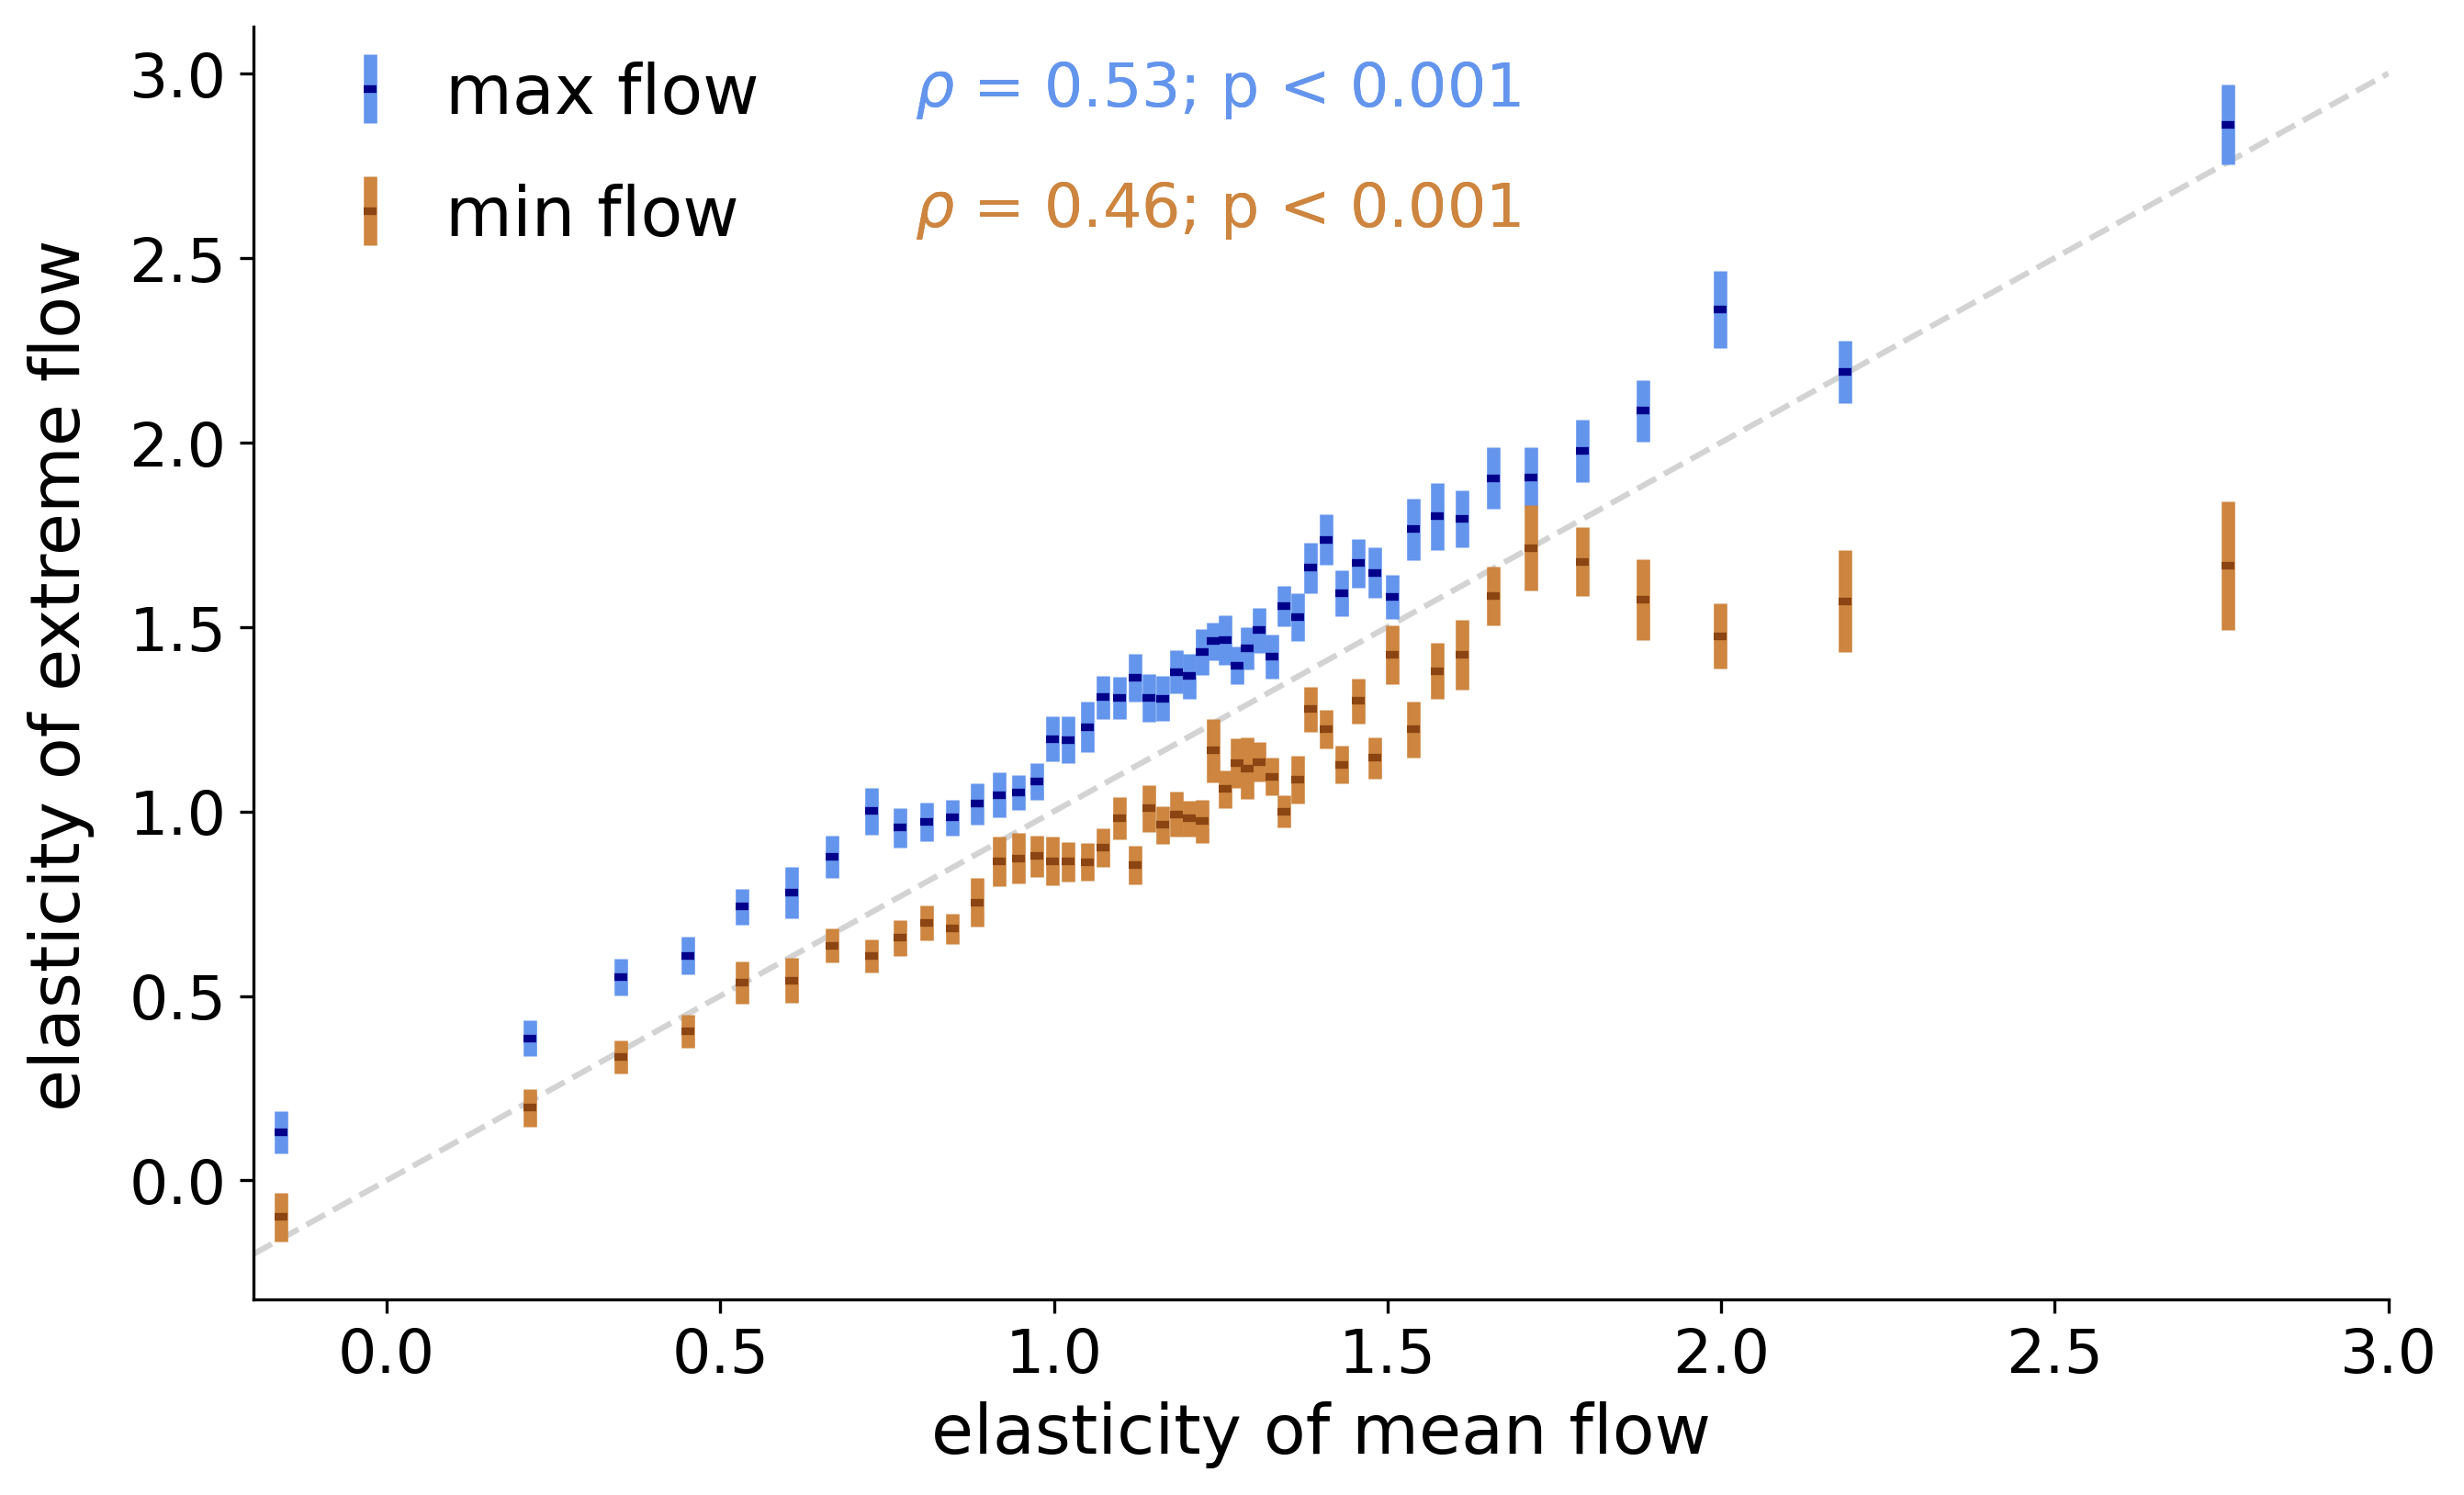

In [19]:
col_pref = 'PmeanTmean_A-P_elas'
result_gdf_mlr_f= result_gdf_mlr.dropna(subset=[str('Qmean'+col_pref), str('Qmax'+col_pref), str('Qmin'+col_pref)])
result_gdf_mlr_f= result_gdf_mlr_f[[str('Qmean'+col_pref), str('Qmax'+col_pref), str('Qmin'+col_pref)]].copy()

# Compute correlation
r_max, p_max = spearmanr(result_gdf_mlr_f[str('Qmean'+col_pref)], result_gdf_mlr_f[str('Qmax'+col_pref)])
r_min, p_min = spearmanr(result_gdf_mlr_f[str('Qmean'+col_pref)], result_gdf_mlr_f[str('Qmin'+col_pref)]) 
c_max = 'cornflowerblue'
c_min = 'peru'
                      
# Create bins for col_mean (2% intervals)
result_gdf_mlr_f['bins'] = pd.qcut(result_gdf_mlr_f[str('Qmean'+col_pref)], q=50) #, duplicates='drop')  # 50 bins = 2% each

# Group by bins and calculate mean and standard error for col_max and col_min
binned_stats = result_gdf_mlr_f.groupby('bins').agg(mean_mean=(str('Qmean'+col_pref), 'mean'),
                                             max_mean=(str('Qmax'+col_pref), 'mean'),
                                             min_mean=(str('Qmin'+col_pref), 'mean'),
                                             max_se=(str('Qmax'+col_pref), sem),
                                             min_se=(str('Qmin'+col_pref), sem)).reset_index()

# Plot
fig, ax = plt.subplots(figsize=(10, 6), facecolor='none', dpi=300)
inset_ax = plt.gca()
inset_ax.patch.set_alpha(0)
ax.axline((0,0), slope=1, color='lightgray', linestyle='--')

plt.errorbar(x=binned_stats['mean_mean'],
             y=binned_stats['max_mean'],
             yerr=binned_stats['max_se'], xerr=None,  
             ecolor=c_max, color='darkblue', elinewidth=3.5, # barsabove=True
             marker='_', markeredgewidth=2, markersize=3.5, linestyle='none', label='max flow') 

plt.errorbar(x=binned_stats['mean_mean'],
             y=binned_stats['min_mean'],
             yerr=binned_stats['min_se'], xerr=None, 
             ecolor=c_min, color='saddlebrown', elinewidth=3.5, # barsabove=True
            marker='_', markeredgewidth=2, markersize=3.5, linestyle='none', label='min flow') 

plt.legend(fontsize=ft, frameon=False, bbox_to_anchor=(0.25, 0.995), handletextpad=0.1, borderaxespad=0., labelspacing=0.8)

# Text box content
text_max = rf"$\rho$ = {r_max:.2f}; p {'< 0.001' if p_max < 0.001 else f'= {p_max:.3f}'}"
text_min = rf"$\rho$ = {r_min:.2f}; p {'< 0.001' if p_min < 0.001 else f'= {p_min:.3f}'}"

# Add textbox below the legend
plt.gca().add_artist(plt.text(0.31, 0.975,  # Adjust position 
                              text_max, fontsize=ft-2, color=c_max, transform=plt.gca().transAxes, 
                              verticalalignment='top', horizontalalignment='left',
                              bbox=dict(facecolor='none', edgecolor='none', boxstyle='round,pad=0.3')))

plt.gca().add_artist(plt.text(0.31, 0.88,  # Adjust position 
                              text_min, fontsize=ft-2, color=c_min,  transform=plt.gca().transAxes, 
                              verticalalignment='top', horizontalalignment='left', 
                              bbox=dict(facecolor='none', edgecolor='none', boxstyle='round,pad=0.3')))

plt.xlabel('elasticity of mean flow', fontsize=ft)
plt.ylabel('elasticity of extreme flow ', fontsize=ft, labelpad=9)
plt.xticks(fontsize=ft-2)
plt.yticks(fontsize=ft-2)
plt.xlim(-0.1,3)
plt.xlim(-0.2,3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig(fp_figures/f"03_sensitivities/01_hyearly/scatters/A-{MON_str}_elasQmean-elasQextreme_mlr.png", dpi=300, bbox_inches='tight')
fig.savefig(fp_figures/f"03_sensitivities/01_hyearly/scatters/A-{MON_str}_elasQmean-elasQextreme_mlr.pdf", bbox_inches='tight')
plt.show()

### Understand the similarities in elasticities for $Q_{max}$ and $Q_{mean}$

The similarity could be explained by either 

- wetter (drier) years leading to a wetter (drier) landscape producing larger (smaller) maximum flows or
- the mean precipitation of a hydrological year being correlated with maximum precipitation. 

To test this we compute the correlation of the mean precipitation to the maximum precipitation.

To check the hypothesis further we plot the elasticity of $Q_{max}$ and $P_{mean}$ ($\epsilon^{Qmax}_{Pmean}$) is in places where $P_{max}$ and $P_{mean}$ are highly correlated.

In [20]:
%%time
P_mean_hyr = pd.read_csv(fp_processed/f"02_temporal_stats/02_hyearly/hyearly_A-{MON_str}_Pmean.csv", index_col=0, parse_dates=[0])[basin_id_sel]
P_max_hyr = pd.read_csv(fp_processed/f"02_temporal_stats/02_hyearly/hyearly_A-{MON_str}_Pmax.csv", index_col=0, parse_dates=[0])[basin_id_sel]

def compute_P_correlations(corr_str="spearmanr"):
    """
    Compute correlations and p-values for corresponding columns in DataFrames Pmean and Pmax.
    
    Parameters:
    - method (str): Type of correlation ("spearmanr" or "pearsonr").
    
    Returns:
    - result_df(pandas.DataFrame): DataFrame with location index, correlation coefficients, and p-values.
    """
    correlations = []
    p_values = []
    
    for col in P_mean_hyr.columns:
        if corr_str == "spearmanr":
            rho, p_val = spearmanr(P_mean_hyr[col], P_max_hyr[col])
        elif corr_str == "pearsonr":
            # Compute Pearson correlation
            rho = np.corrcoef(P_mean_hyr[col], P_max_hyr[col])[0, 1]  # Pearson r
            
            # Compute p-value using t-statistic
            n = len(P_mean_hyr[col])
            t_stat = rho * np.sqrt((n - 2) / (1 - rho ** 2))
            p_val = 2 * t.sf(np.abs(t_stat), df=n - 2)  # Two-tailed test
            
        else:
            raise ValueError("Invalid method. Choose 'spearman' or 'pearson'.")
        
        correlations.append(rho)
        p_values.append(p_val)
    
    # Create a DataFrame for the results
    result_df = pd.DataFrame({
        'basin_id': P_mean_hyr.columns,
        corr_str: correlations,
        'p_value': p_values
    }).set_index('basin_id')

    return result_df

Pmean_Pmax_corr = compute_P_correlations(corr_str="spearmanr")

CPU times: user 3.64 s, sys: 42.5 ms, total: 3.69 s
Wall time: 3.53 s


/var/folders/gx/zty05h6s2_555flc2721fjrc0000gn/T/ipykernel_4328/3809190023.py:69: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  gpdf_corr_insig.plot(ax=ax1, column=corr_str, label='insignificant',# ($p \leq 0.05$)',
/var/folders/gx/zty05h6s2_555flc2721fjrc0000gn/T/ipykernel_4328/3809190023.py:135: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()#pad=0.3, w_pad=0.3)


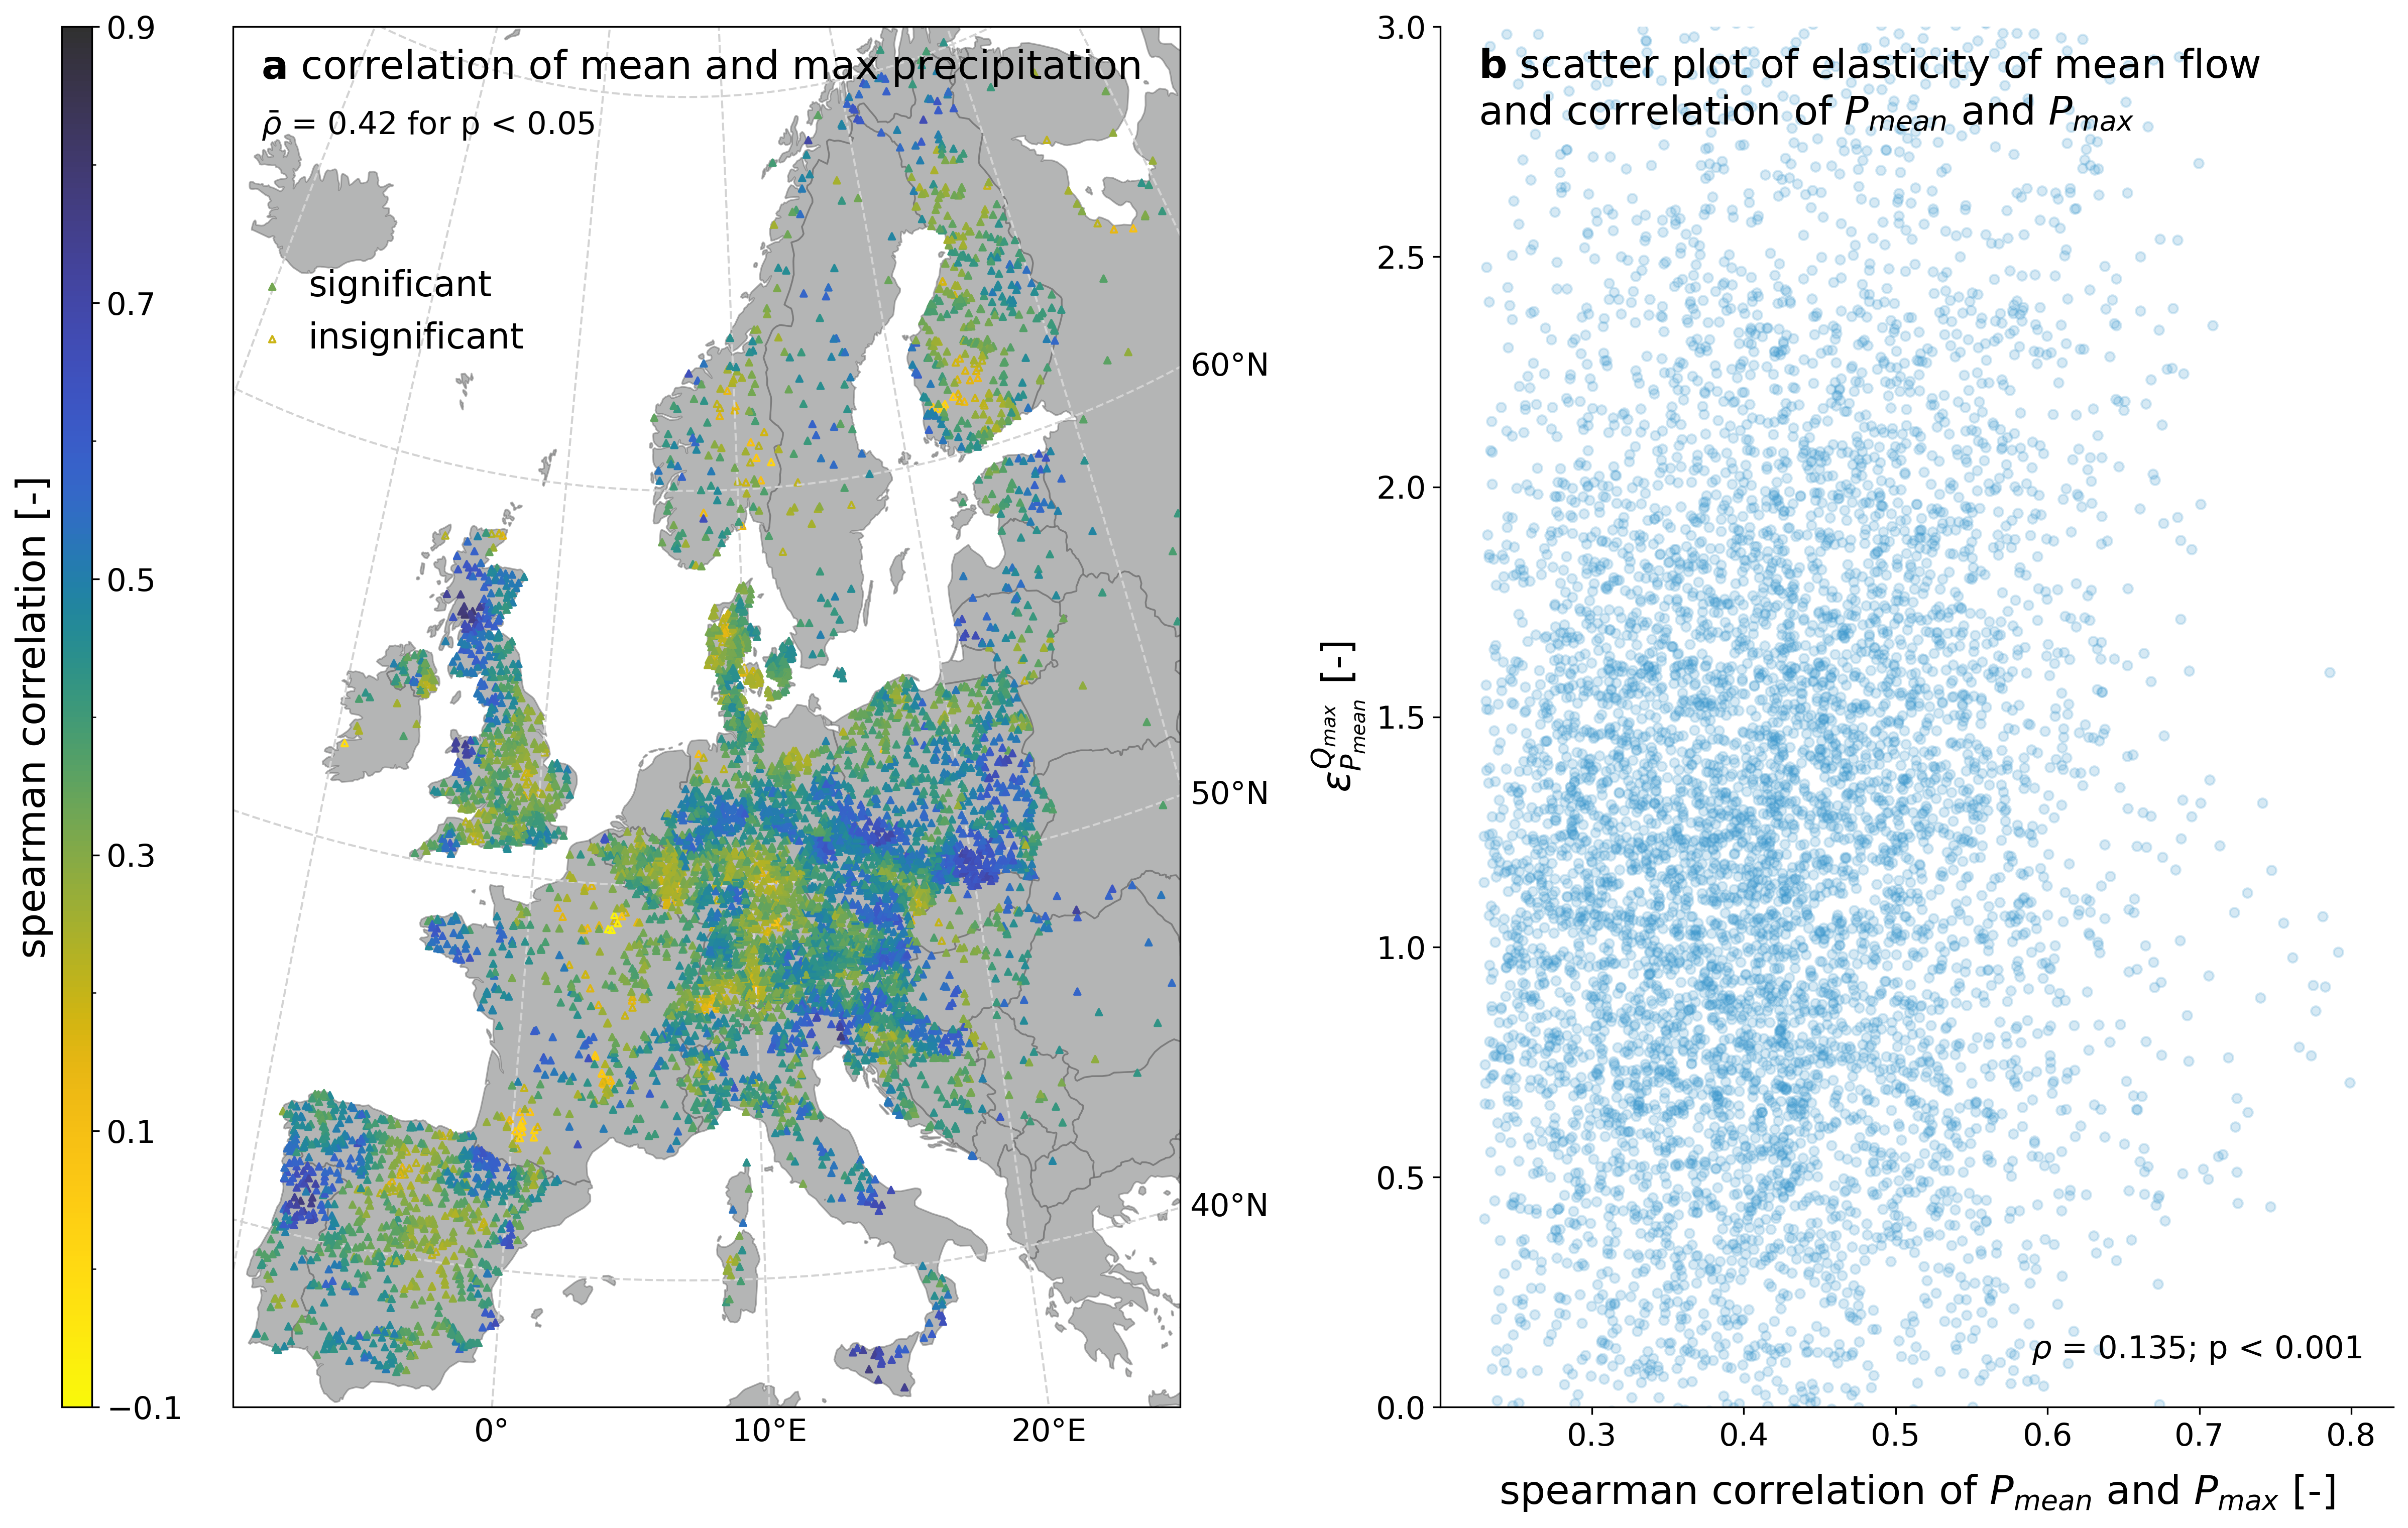

In [21]:
#europe_extent = [-11.5, 26.75, 35.5, 60]

def plot_P_corr_maps(corr_df=Pmean_Pmax_corr, gdf=result_gdf_mlr, 
                     col_name='QmaxPmeanTmean_A-P_elas', 
                     vmin=-0.1, vmax=0.9, corr_str='spearmanr'):
    """
    Plots two geographic scatter plots next to each other: one for slope and one for r2, with corresponding colors and saves them into a png.
    The colors in the map are grouped into classes. 

    Parameters:
    - corr_df (pandas.DataFrame): DataFrame of the correlations of Pmax and Pmean, e.g. Pmean_Pmax_corr.
    - gdf (geopandas.GeoDataFrame): GeoDataFrame, e.g. result_gdf_mlr. 
    - col_name (str): Column name of the elasticity, e.g. 'QmaxPmeanTmean_A-P_elas'.
    - vmin (float): Minimum value of the correlation to display.
    - vmax (float): Maximum value of the correlation to display. 
    - corr_str(str): Type of correlation, e.g 'spearmanr'.
    
    Returns:
    - None
    """
    # Merge gpd with the correlation df
    europe_extent = [-9.5, 25, 36.7, 71] #[-9.5, 27, 36.7, 71]
    prj_lambert = ccrs.LambertAzimuthalEqualArea(central_longitude=7, central_latitude=53) #(central_longitude=9, central_latitude=54) 
    gdf_proj = gdf.to_crs(prj_lambert)
    extent_crs = ccrs.PlateCarree()
    
    gpdf_corr = gdf_proj.merge(corr_df, on='basin_id', how='inner')
    gpdf_corr_sig = gpdf_corr[gpdf_corr['p_value']<0.05]
    gpdf_corr_insig = gpdf_corr[gpdf_corr['p_value']>=0.05]
    
    # Set up the plot
    map_w = 8.5 #7
    map_h = 11.9 #12 #map_w / aspect_ratio
    cbar_w = 0.27
    cbar_pad = 0.3
    pad_w = 0.9
    
    ft = 15
    total_w = cbar_w + pad_w + map_w + pad_w + pad_w + map_w 

    # GridSpec and layout
    ws = [cbar_w, pad_w, map_w, pad_w, pad_w, map_w]
    gs = GridSpec(1, 6, width_ratios=ws, wspace=0.05)
    total_w = sum(gs.get_width_ratios()) 
    fig = plt.figure(figsize=(total_w, map_h), dpi=300)
    fig.patch.set_alpha(0)

    # Colorbar
    cax = fig.add_subplot(gs[0])
    cmap = cc.m_CET_L20_r
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
    cb.set_label(r'spearman correlation [-]', fontsize=ft+4)
    cb.ax.yaxis.set_label_position('left')
    cb.ax.tick_params(labelsize=ft)
    cb.ax.set_yticks(np.arange(vmin, vmax+0.1, 0.2))
    cb.ax.set_yticks(np.arange(vmin, vmax+0.1, 0.1), minor=True)
    
    ax1 = fig.add_subplot(gs[2], projection=prj_lambert) 
    ax1.set_extent(europe_extent, crs=ccrs.PlateCarree()) #the projection the data is in
    ax1.set_aspect('equal')
    ax1.set_facecolor('white')

    gpdf_corr_sig.plot(ax=ax1, column=corr_str, label='significant', # ($p < 0.05$)',
                       cmap=cmap, edgecolor=gpdf_corr_sig[corr_str].map(lambda x: cmap(norm(x))), #transform=ccrs.PlateCarree(),
                       alpha=1, marker='^', markersize=9,  # Adjust dot size
                       vmin=vmin, vmax=vmax,  zorder=3)
    
    gpdf_corr_insig.plot(ax=ax1, column=corr_str, label='insignificant',# ($p \leq 0.05$)', 
                         color='none', edgecolor=gpdf_corr_insig[corr_str].map(lambda x: cmap(norm(x))),#edgecolor=cmap, transform=ccrs.PlateCarree(),
                         alpha=1, marker='^', markersize=9,  # Adjust dot size
                         vmin=vmin, vmax=vmax, zorder=2)

    europe.boundary.plot(ax=ax1, transform=extent_crs, #prj_lambert, #ccrs.PlateCarree(),
                         edgecolor='dimgrey', facecolor='#6B6C6D',  #'#DCDCDC', 'whitesmoke', 'darkgray'
                         alpha=0.5, linewidth=0.8, zorder=1)
        
    # Gridlines
    gl = ax1.gridlines(draw_labels=True, linewidth=1, color='lightgray', linestyle='--')
    # Set major gridlines at 10-degree intervals for both longitude and latitude
    gl.xlocator = ticker.MultipleLocator(10)  # Longitude gridlines every 10 degrees
    gl.ylocator = ticker.MultipleLocator(10)  # Latitude gridlines every 10 degrees

    gl.top_labels = gl.left_labels = False
    gl.right_labels = True
    gl.bottom_labels = True
    gl.xlabel_style = {'size': ft, 'color': 'k'}
    gl.ylabel_style = {'size': ft, 'color': 'k'}

    # Title
    ax1.text(0.03, 0.985,  #x=0.07, y=0.915
            r'$\bf{a}$ correlation of mean and max precipitation', transform=ax1.transAxes, #$P_{mean}$ and $P_{max}$
            fontsize=ft+4, va='top', ha='left',
            bbox=dict(facecolor='none', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))
        
    # Legend 
    ax1.legend(fontsize=ft+2, bbox_to_anchor=(0.33, 0.84), # bbox_to_anchor=(0.7, 0.1),
               handletextpad=0.01, borderpad=0.1, alignment='left', frameon=False)
    
    r_sig_mean = gpdf_corr_sig[corr_str].mean()
    text_mean = rf"$\bar{{\rho}}$ = {r_sig_mean:.2f} for p < 0.05"
    
    # Add textbox below the legend
    ax1.text(0.03, 0.94, text_mean, fontsize=ft, color='black',  
            transform=ax1.transAxes, verticalalignment='top', horizontalalignment='left',
            bbox=dict(facecolor='none', edgecolor='none', boxstyle='round,pad=0.3'))
    
    # Set up the figure and axes
    ax3 = fig.add_subplot(gs[5]) 
    ax3.set_facecolor('white') # Keep the map (axes) background white
    ax3.set_title(fr'$\bf{{b}}$ scatter plot of elasticity of mean flow'+'\n'+
                      r'and correlation of $P_{mean}$ and $P_{max}$',
                      fontsize=ft+4, ha='left', x=0.04, y=0.92)  # Move title inside
    ax3.scatter(gpdf_corr_sig['spearmanr'], gpdf_corr_sig[col_name], s=20, alpha=0.2, color='#3594cc')
    ax3.set_ylim(0, 3)
    #ax3.set_xlim(0, 2.2)
    ax3.set_ylabel(str('$\epsilon^{Q_{max}}_{P_{mean}}$ [-]'), fontsize=ft+4)
    ax3.set_xlabel(str('spearman correlation of $P_{mean}$ and $P_{max}$ [-]'), fontsize=ft+4, labelpad=10)
    ax3.tick_params(axis='both', labelsize=ft) #plt.tick_params(axis='both', labelsize=ft)

    # Remove top and left spines
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    #axes.axvline(x=0,linestyle='--', linewidth=1, color='lightgray')   

    # Add textbox below the legend
    gpdf_corr_sig = gpdf_corr_sig.dropna(subset=[col_name])
    rho_, p_val_ = spearmanr(gpdf_corr_sig['spearmanr'], gpdf_corr_sig[col_name])
    text_ = rf"$\rho$ = {rho_:.3f}; p {'< 0.001' if p_val_ < 0.001 else f'= {p_val_:.2f}'}"
    ax3.text(0.62, 0.03,text_, fontsize=ft, color='black',  transform=ax3.transAxes, 
             verticalalignment='bottom', horizontalalignment='left', 
             bbox=dict(facecolor='none', edgecolor='none', boxstyle='round,pad=0.3'))

    # Adjust layout, save, and show
    plt.tight_layout()#pad=0.3, w_pad=0.3)
    plt.savefig(fp_figures/f"03_sensitivities/01_hyearly/maps/A-{MON_str}_PmeanPmax_{corr_str}-corr-map+elas-scatter.png", dpi=300, bbox_inches='tight')
    plt.savefig(fp_figures/f"03_sensitivities/01_hyearly/maps/A-{MON_str}_PmeanPmax_{corr_str}-corr-map+elas-scatter.pdf", bbox_inches='tight')
    plt.show();
    return 

plot_P_corr_maps(corr_df=Pmean_Pmax_corr, corr_str='spearmanr')

## Alternative approach: hierarchical linear regression

We compare the previous approach with a hierarchical linear regression approach, where we fit a linear regression per catchment through the pairs of normalized Q and P to get the elasticity (slope). In a second step we conduct a linear regressino between the residuals from the Q-P regression and the absolute T timeseries(to see if the residuals from this regression can be explained with T). We try different types of linear regresion:
- **Linear regression**
- **Robust liner regression**: a robust method for fitting a model to data that may contain outliers. It works by iteratively selecting a random subset of the data, fitting a model to that subset, and then determining how well the model fits the rest of the data. Points that do not fit the model well are considered outliers.
- **Theil-sen slope**: a non-parametric method for robust linear regression. It calculates the median of slopes of all lines through pairs of data points, making it robust to outliers.
- **Huber Regressor**: a linear model that combines the squared loss (used in standard linear regression) for small residuals and the absolute loss for large residuals. This makes it more robust to outliers compared to standard least squares.

### Linear regression of precipitation and streamflow

In [22]:
model_type_dict = {'slr': 'linear', 'tlr': 'theilsen', 'rlr': 'ransac'} #model_type (str): Type of regression e.g., 'linear', 'ransac', 'theilsen'

In [23]:
def regression_model(model_type):
    """
    Returns a regression model instance from string input and returns an error if the string input is invalid.
    
    Parameters:
    - model_type (str): Regression model instance e.g. 'linear', 'ransac', 'theilsen'
    
    Returns:
    - p_value: Regression model instance.
    """
    models = {
        'linear': linregress, #LinearRegression,
        'ransac': lambda: RANSACRegressor(estimator=LinearRegression()), #Random Sample Consensus
        'theilsen': theilslopes, #TheilSenRegressor,
    }
    if model_type not in models:
        raise ValueError(f"Invalid model type. Choose from {list(models.keys())}.")
        
    return models[model_type]
    
def linear_regression(x, y, QP_combi_str, lr_str, t_scale, min_data_pts=15, ci=0.90):
    """
    Perform regression analysis for different types of linear regression on each basin.

    Parameters:
    - x (DataFrame): Normalized parameter e.g., P_mean_hyr_norm
    - y (DataFrame): Normalized discharge e.g., Q_mean_hyr_norm_nnan
    - QP_combi_str (str): Name of the Q and P variable, e.g. QmeanPmean
    - lr_str (str): String for the output file of the low_data_basins, e.g. slr
    - t_scale (str): String for the output file of the low_data_basins e.g., annual
    - min_data_pts (int): Minimum amount of years with overlapping data as input for the linear regression e.g. 10
    - ci (float): Confidence interval e.g. 0.90 for 90%

    Returns:
    - DataFrame: DataFrame with slopes, intercepts, and R^2 values for each basin.
    """
    model_class = regression_model(model_type_dict[lr_str])
    elas = pd.DataFrame(columns=['P_elas', 'b', 'r2', 'p_value', 'lower_ci', 'upper_ci', 'ci_range', 'std_err'])
    low_data_bsns = []  # List to store basins with insufficient data

    for basin in x.columns:
        mask = x[basin].notna() & y[basin].notna() #this ignores that one df has its datetime index in october and the other one in december
        x_nonnan = x[basin][mask].values
        y_nonnan = y[basin][mask].values

        if len(x_nonnan) >= min_data_pts:
            if model_type_dict[lr_str] == 'linear':
                # Perform simple linear regression
                slope, intercept, r_value, p_value, std_err = linregress(x_nonnan, y_nonnan)
                r2 = r_value**2
                t_crit = t.ppf((1 + ci) / 2, df=len(x_nonnan) - 2) #represents the critical val from the t-distribution for a given confidence level and degrees of freedom. Used to determine the range of values within which we can be confident (e.g., 95%) that the true slope lies.
                lower_ci = slope - t_crit * std_err
                upper_ci = slope + t_crit * std_err
                
            elif model_type_dict[lr_str] == 'theilsen':
                # Perform Theil-Sen regression
                slope, intercept, lower_ci, upper_ci = theilslopes(y_nonnan, x_nonnan.flatten(), alpha=1-ci)
                
                # Two-tailed test against zero slope
                p_value = np.nan #(np.sum(np.abs(bs_slopes) >= np.abs(0)) + 1) / (len(bs_slopes) + 1)
                std_err = np.nan
                # Compute predictions and R^2
                y_pred = slope * x_nonnan + intercept
                r2 = r2_score(y_nonnan, y_pred)
                
            ci_range = upper_ci - lower_ci
            elas.loc[basin] = [slope, intercept, r2,
                               round(p_value, 6) if not np.isnan(p_value) else np.nan,
                               round(lower_ci, 6) if not np.isnan(lower_ci) else np.nan,
                               round(upper_ci, 6) if not np.isnan(upper_ci) else np.nan,
                               round(ci_range, 6) if not np.isnan(ci_range) else np.nan,
                               round(std_err, 6) if not np.isnan(std_err) else np.nan]
        else:
            low_data_bsns.append(basin) # Add basin to the list

    elas.index.name = 'basin_id'
    
    # Export low_data_basins to a CSV file
    pd.DataFrame({'low_data_basins': low_data_bsns}).to_csv(
        fp_processed/f"03_sensitivities/01_hyearly/low_data_basins/A-{MON_str}_{t_scale}_{lr_str}_{QP_combi_str}_P_low_data_basins.csv", index=False)
    
    return elas

lr_types = {
        'slr': 'simple lin. reg.',
        'rlr': 'robust lin. reg.',
        'tlr': 'theil-sen lin. reg.',
}

#### Annual precipitation elasticity of all streamflow variables

In [24]:
%%time
##---ONLY RE-RUN IF WE WANT TO UPDATE THE CALCULATION, ELSE READ OUTPUT IN---##
ci = 0.9

## tlr
QmeanPmean_elas_tlr = linear_regression(x=Pmean_hyr_norm_QmeanPmean, y=Qmean_hyr_norm_QmeanPmean, QP_combi_str = 'QmeanPmean', lr_str='tlr', t_scale='annual', ci=ci) 
QmeanPmean_elas_tlr.to_csv(fp_processed/f"03_sensitivities/01_hyearly/hyearly_A-{MON_str}_elas_QmeanPmean_tlr.csv")

Q1dmaxPmean_elas_tlr = linear_regression(x=Pmean_hyr_norm_Q1dmaxPmean, y=Q1dmax_hyr_norm_Q1dmaxPmean, QP_combi_str = 'Q1dmaxPmean', lr_str='tlr', t_scale='annual', ci=ci)  
Q1dmaxPmean_elas_tlr.to_csv(fp_processed/f"03_sensitivities/01_hyearly/hyearly_A-{MON_str}_elas_Q1dmaxPmean_tlr.csv")

Q1dmaxPmax_elas_tlr = linear_regression(x=Pmax_hyr_norm_Q1dmaxPmax, y=Q1dmax_hyr_norm_Q1dmaxPmax, QP_combi_str = 'Q1dmaxPmax', lr_str='tlr', t_scale='annual', ci=ci) 
Q1dmaxPmax_elas_tlr.to_csv(fp_processed/f"03_sensitivities/01_hyearly/hyearly_A-{MON_str}_elas_Q1dmaxPmax_tlr.csv")

Q1dminPmean_elas_tlr = linear_regression(x=Pmean_hyr_norm_Q1dminPmean, y=Q1dmin_hyr_norm_Q1dminPmean, QP_combi_str = 'Q1dminPmean', lr_str='tlr', t_scale='annual', ci=ci) 
Q1dminPmean_elas_tlr.to_csv(fp_processed/f"03_sensitivities/01_hyearly/hyearly_A-{MON_str}_elas_Q1dminPmean_tlr.csv")

Q7dminPmean_elas_tlr = linear_regression(x=Pmean_hyr_norm_Q7dminPmean, y=Q7dmin_hyr_norm_Q7dminPmean, QP_combi_str = 'Q7dminPmean', lr_str='tlr', t_scale='annual', ci=ci)  
Q7dminPmean_elas_tlr.to_csv(fp_processed/f"03_sensitivities/01_hyearly/hyearly_A-{MON_str}_elas_Q7dminPmean_tlr.csv")

CPU times: user 32.7 s, sys: 153 ms, total: 32.9 s
Wall time: 33.1 s


In [25]:
%%time
result_gdf_hlr_P = result_gdf.copy()
for elas, combi_str in zip([QmeanPmean_elas_tlr, Q1dmaxPmean_elas_tlr, Q7dminPmean_elas_tlr, Q1dmaxPmax_elas_tlr],
                          ['QmeanPmean', 'QmaxPmean', 'QminPmean', 'QmaxPmax']):
    for col in ['P_elas', 'r2', 'b', 'lower_ci', 'upper_ci', 'ci_range']:
        elas = elas.rename(columns={col: str(combi_str+'_A-'+col)}) 
        result_gdf_hlr_P = result_gdf_hlr_P.merge(elas[[str(combi_str+'_A-'+col)]], on='basin_id', how='inner')
        
result_gdf_hlr_P.to_csv(fp_processed/f"03_sensitivities/01_hyearly/hyearly_Pelas_hlr_summary.csv")

CPU times: user 193 ms, sys: 6.01 ms, total: 199 ms
Wall time: 201 ms


### Linear regression of temperature and residuals

Temperature is not normalized but kept in absolute values due to the nature of the unit celcius.

In [26]:
%%time

def linear_regression_T(elas, Q, P, T, QP_combi_str, lr_str='tlr', min_data_pts=15, ci=0.90):
    """
    Perform regression analysis for different types of linear regression on each basin. 
    This uses the Ep timeseries per catchment as the x variable and the residual of the precipitation 
    elasticity of streamflow as the y variable.
    The parameters elas, Q and P are used to compute the residuals. 
    The residuals and Ep are used to compute the linear regression.

    Parameters:
    - x (DataFrame): Normalized parameter e.g., Tmean_hyr
    - y (DataFrame): Normalized discharge e.g., Qmean_hyr_norm_nnan
    - lr_str (str): String for the outpufile of the low_data_basins e.g., QmeanPmean_slr
    - min_data_pts (int): Minimum amount of years with overlapping data as input for the linear regression e.g. 10
    - ci (float): Confidence interval e.g. 0.90 for 90%

    Returns:
    - DataFrame: DataFrame with slopes, intercepts, and R^2 values for each basin.
    """
    model_class = regression_model(model_type_dict[lr_str])
    sens = pd.DataFrame(columns=[str(QP_combi_str+'_Tmean_A-T_sens'),
                                 str(QP_combi_str+'_Tmean_A-b'),
                                 str(QP_combi_str+'_Tmean_A-r2'),
                                 str(QP_combi_str+'_Tmean_A-lower_ci'),
                                 str(QP_combi_str+'_Tmean_A-upper_ci'),
                                 str(QP_combi_str+'_Tmean_A-ci_range')])
    low_data_bsns = []  # List to store basins with insufficient data

    # Initialize a DataFrame to store residuals
    residuals = pd.DataFrame(index=P.index, columns=P.columns)

    # Loop through each location
    for basin in elas.index:
        # First we are in a P-Q space where P is on the X axis and Q on the Y axis
        a = elas.loc[elas.index == basin, 'P_elas'].values[0]  # Slope
        b = elas.loc[elas.index == basin, 'b'].values[0]      # Intercept
        
        X_vals = P[basin]  # Predictor variable (P)
        Y_vals = Q[basin]  # Response variable (Q)
        
        # Compute residuals
        residuals[basin] = Y_vals - (a * X_vals + b)  # actual - model prediction

        # Now we are in a space where Ep is on the x axis and the residuals are on the y axis
        mask = T[basin].notna() & residuals[basin].notna() # x&y
        x_nonnan = T[basin][mask].values #x
        y_nonnan = residuals[basin][mask].values #y

        if len(x_nonnan) >= min_data_pts:
            if model_type_dict[lr_str] == 'linear':
                # Perform simple linear regression
                slope, intercept, r_value, p_value, std_err = linregress(x_nonnan, y_nonnan)
                r2 = r_value**2
                t_crit = t.ppf((1 + ci) / 2, df=len(x_nonnan) - 2) #represents the critical val from the t-distribution for a given confidence level and degrees of freedom. Used to determine the range of values within which we can be confident (e.g., 95%) that the true slope lies.
                lower_ci = slope - t_crit * std_err
                upper_ci = slope + t_crit * std_err
                
            elif model_type_dict[lr_str] == 'theilsen':
                #assert np.all(np.isfinite(x_nonnan)), "x_nonnan contains non-finite values."
                #assert np.all(np.isfinite(y_nonnan)), "y_nonnan contains non-finite values."
                # Perform Theil-Sen regression
                slope, intercept, lower_ci, upper_ci = theilslopes(y_nonnan, x_nonnan.flatten(), alpha=1-ci)
                
                # Compute predictions and R^2
                y_pred = slope * x_nonnan + intercept
                r2 = r2_score(y_nonnan, y_pred)
                
            ci_range = upper_ci - lower_ci
            sens.loc[basin] = [slope, intercept, r2,
                               round(lower_ci, 6) if not np.isnan(lower_ci) else np.nan,
                               round(upper_ci, 6) if not np.isnan(upper_ci) else np.nan,
                               round(ci_range, 6) if not np.isnan(ci_range) else np.nan]
        else:
            low_data_bsns.append(basin) # Add basin to the list

    sens.index.name = 'basin_id'
    
    # Export low_data_basins to a CSV file
    pd.DataFrame({'low_data_basins': low_data_bsns}).to_csv(
        fp_processed/f"03_sensitivities/01_hyearly/low_data_basins/A-{MON_str}_{QP_combi_str}_{lr_str}_PQresidual-T_hlr-low_data_basins.csv", index=False)
    
    return sens

## tlr
QmeanPmean_Tmean_sens_tlr = linear_regression_T(elas=QmeanPmean_elas_tlr, Q=Qmean_hyr_norm_QmeanPmean, P=Pmean_hyr_norm_QmeanPmean, 
                                                T=Tmean_hyr, QP_combi_str='QmeanPmean')
Q1dmaxPmean_Tmean_sens_tlr = linear_regression_T(elas=Q1dmaxPmean_elas_tlr, Q=Q1dmax_hyr_norm_Q1dmaxPmean, P=Pmean_hyr_norm_Q1dmaxPmean, 
                                                 T=Tmean_hyr, QP_combi_str='QmaxPmean')
Q7dminPmean_Tmean_sens_tlr = linear_regression_T(elas=Q7dminPmean_elas_tlr, Q=Q7dmin_hyr_norm_Q7dminPmean, P=Pmean_hyr_norm_Q7dminPmean, 
                                                 T=Tmean_hyr, QP_combi_str='QminPmean')
Q1dmaxPmax_Tmean_sens_tlr = linear_regression_T(elas=Q1dmaxPmax_elas_tlr, Q=Q1dmax_hyr_norm_Q1dmaxPmax, P=Pmax_hyr_norm_Q1dmaxPmax, 
                                                T=Tmean_hyr, QP_combi_str='QmaxPmax')

CPU times: user 39.9 s, sys: 58.4 ms, total: 40 s
Wall time: 40.1 s


In [27]:
%%time
result_gdf_hlr = result_gdf_hlr_P.copy()
for sens, combi_str in zip([QmeanPmean_Tmean_sens_tlr, Q1dmaxPmean_Tmean_sens_tlr, Q7dminPmean_Tmean_sens_tlr, Q1dmaxPmax_Tmean_sens_tlr],
                          ['QmeanPmean', 'QmaxPmean', 'QminPmean', 'QmaxPmax']):
    for col in ['T_sens', 'r2', 'b', 'lower_ci', 'upper_ci', 'ci_range']:
        #sens = sens.rename(columns={col: str(combi_str+'_Tmean_'+col)})
        result_gdf_hlr = result_gdf_hlr.merge(sens[[str(combi_str+'_Tmean_A-'+col)]], on='basin_id', how='inner')
        
result_gdf_hlr.to_csv(str(fp_processed/'03_sensitivities/01_hyearly/hyearly_PelasTsens_hlr_summary.csv'))

CPU times: user 267 ms, sys: 8.5 ms, total: 275 ms
Wall time: 277 ms


# Compare results from multiple linear regression with hierarchical linear regressions.

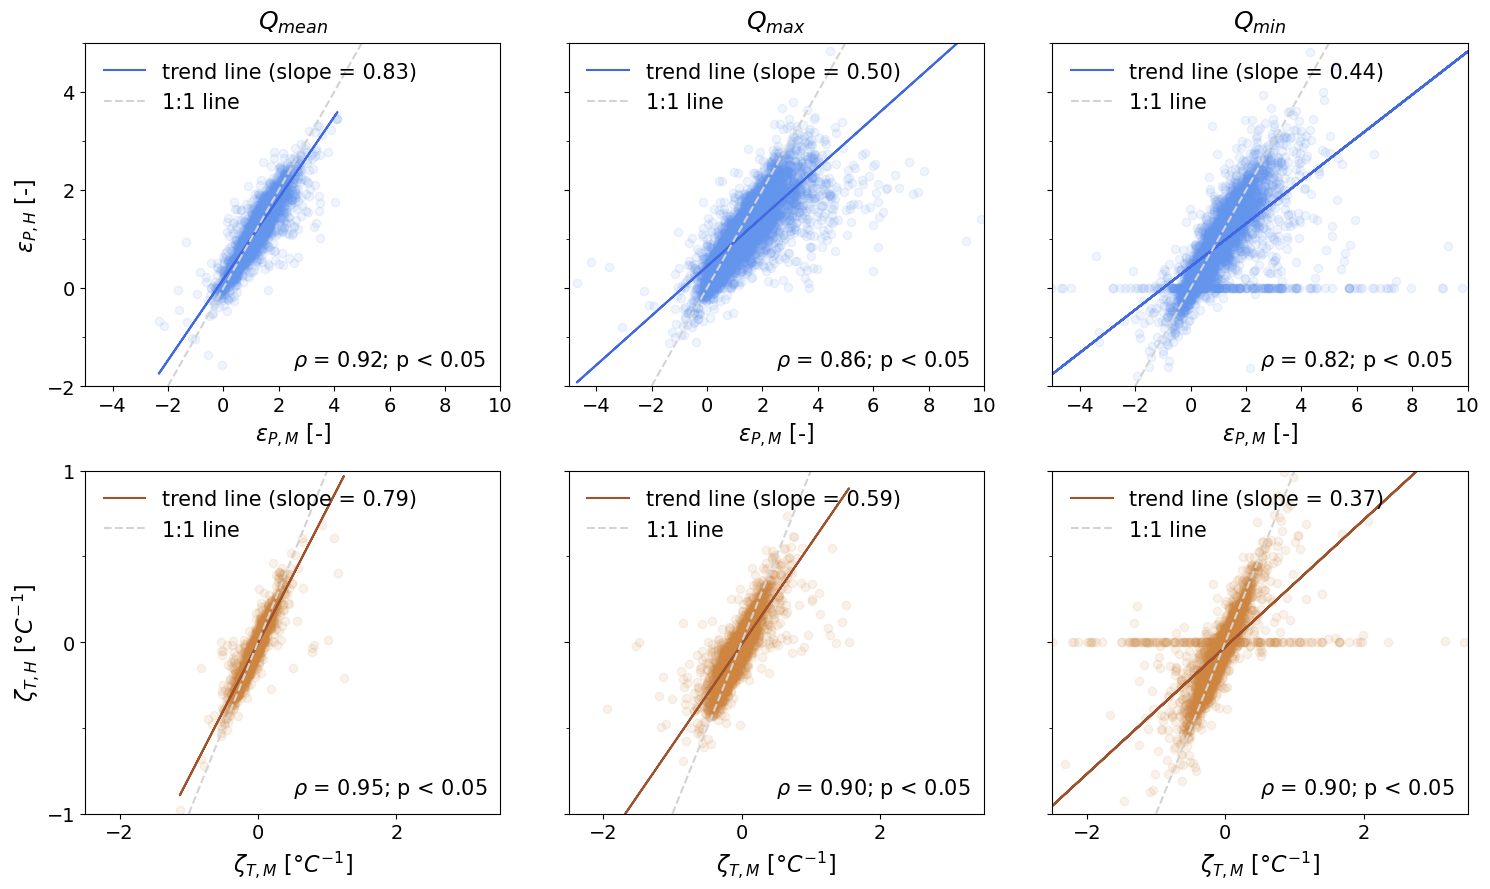

In [28]:
ft=14

x_cols = [QmeanPmeanTmean_mlr, QmaxPmeanTmean_mlr, QminPmeanTmean_mlr]
y_cols = ['QmeanPmean_A-P_elas', 'QmaxPmean_A-P_elas', 'QminPmean_A-P_elas']
y_cols_T = ['QmeanPmean_Tmean_A-T_sens', 'QmaxPmean_Tmean_A-T_sens', 'QminPmean_Tmean_A-T_sens']

fig, axes = plt.subplots(2, 3, figsize=(15, 9)) #, sharey=True)
plt.subplots_adjust(wspace=0.01, hspace=0.18)
fig.patch.set_alpha(0)
axes[0, 1].sharey(axes[0, 0])
axes[0, 2].sharey(axes[0, 0])
axes[1, 1].sharey(axes[1, 0])
axes[1, 2].sharey(axes[1, 0])
axes[0, 0].yaxis.set_major_locator(ticker.MultipleLocator(2))
axes[0, 0].yaxis.set_minor_locator(ticker.MultipleLocator(1))
axes[1, 0].yaxis.set_major_locator(ticker.MultipleLocator(1))
axes[1, 0].yaxis.set_minor_locator(ticker.MultipleLocator(0.5))

for row in axes: 
    for ax in row[1:]:
        ax.set_ylabel('')
        ax.tick_params(labelleft=False)

for i, (x_df, y_col) in enumerate(zip(x_cols, y_cols)):
    common_ids = result_gdf_hlr.index.intersection(x_df.index)
    hierarch_common = result_gdf_hlr.loc[common_ids]
    ols_common = x_df.loc[common_ids]
    
    ax = axes[0, i]
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    x = np.array(ols_common['P_elas'], dtype=float) #ols_common['P_elas']
    y = np.array(hierarch_common[y_col], dtype=float) #hierarch_common[y_col]
    ax.scatter(x, y, alpha=0.1, color='cornflowerblue')
    slope, intercept = np.polyfit(x, y, 1)
    ax.plot(x, slope * x + intercept, color='royalblue', label=f"trend line (slope = {slope:.2f})") # fitting a ploynomial of degree 1
    ax.set_xlabel('$\epsilon_{P,M}$ [-]', fontsize=ft+2)
    ax.set_ylabel('$\epsilon_{P,H}$ [-]', fontsize=ft+2, color='black' if i == 0 else (0, 0, 0, 0))
    
    ax.tick_params(axis='both', labelsize=ft)
    ax.set_xlim(-5,10)
    ax.set_ylim(-2,5)
    ax.axline((0,0), slope=1, color='lightgray', linestyle='--', label='1:1 line')
    ax.legend(frameon=False, loc='upper left', fontsize=ft+1)
    rho, p_val = spearmanr(ols_common['P_elas'], hierarch_common[y_col])
    text_ = rf"$\rho$ = {rho:.2f}; p {'< 0.05' if p_val < 0.05 else f'= {p_val:.2f}'}"
    ax.text(0.5, 0.04, text_, transform=ax.transAxes,
                fontsize=ft+1, va='bottom', ha='left',
                bbox=dict(facecolor='none', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))
        
for i, (x_df, y_col) in enumerate(zip(x_cols, y_cols_T)):
    common_ids = result_gdf_hlr.index.intersection(x_df.index)
    hierarch_common = result_gdf_hlr.loc[common_ids]
    ols_common = x_df.loc[common_ids]
    
    ax2 = axes[1, i]
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(2))
    
    x = np.array(ols_common['T_sens'], dtype=float) #ols_common['T_sens']
    y = np.array(hierarch_common[y_col], dtype=float) #hierarch_common[y_col]
    ax2.scatter(x, y, alpha=0.1, color='peru')
    slope, intercept = np.polyfit(x, y, 1)
    ax2.plot(x, slope * x + intercept, color='sienna', label=f"trend line (slope = {slope:.2f})") # fitting a ploynomial of degree 1
    #ax.scatter(ols_common['T_sens'], hierarch_common[y_col], alpha=0.5, color='peru', edgecolor='peru')
    ax2.set_xlabel('$\zeta_{T,M}$ [$°C^{-1}$]', fontsize=ft+2)
    ax2.set_ylabel('$\zeta_{T,H}$ [$°C^{-1}$]', fontsize=ft+2, color='black' if i == 0 else (0, 0, 0, 0))
    ax2.tick_params(axis='both', labelsize=ft)
    ax2.set_xlim(-2.5,3.5)
    ax2.set_ylim(-1,1)
    ax2.axline((0,0), slope=1, color='lightgray', linestyle='--', label='1:1 line')
    ax2.legend(frameon=False, loc='upper left', fontsize=ft+1)
    rho, p_val = spearmanr(ols_common['T_sens'], hierarch_common[y_col])
    text_ = rf"$\rho$ = {rho:.2f}; p {'< 0.05' if p_val < 0.05 else f'= {p_val:.2f}'}"
    ax2.text(0.5, 0.04, text_, transform=ax2.transAxes,
                fontsize=ft+1, va='bottom', ha='left',
                bbox=dict(facecolor='none', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))
    
    
# Plot histograms
axes[0, 0].set_title('$Q_{mean}$', fontsize=ft+4, pad=10)
axes[0, 1].set_title('$Q_{max}$', fontsize=ft+4, pad=10)
axes[0, 2].set_title('$Q_{min}$', fontsize=ft+4, pad=10)

plt.tight_layout()
plt.savefig(fp_figures/f"03_sensitivities/01_hyearly/scatters/A-{MON_str}_mlr-hlr-method-comparison.png", dpi=300, bbox_inches='tight')
plt.savefig(fp_figures/f"03_sensitivities/01_hyearly/scatters/A-{MON_str}_mlr-hlr-method-comparison.pdf", bbox_inches='tight')
plt.show()

# Which catchments are most resilient?

In [29]:
# Define extent corners in lon/lat
europe_extent = [-9.5, 25, 36.7, 71]#[-9.5, 27, 36.7, 71]
min_lon, max_lon, min_lat, max_lat = europe_extent
corners_lonlat = [
    (min_lon, min_lat),  # bottom-left
    (min_lon, max_lat),  # top-left
    (max_lon, min_lat),  # bottom-right
    (max_lon, max_lat),  # top-right
]

# Setup projection transformer: from WGS84 to EPSG:3035
project = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3035", always_xy=True).transform

# Project corners
corners_proj = [project(lon, lat) for lon, lat in corners_lonlat]

# Compute width and height in projected units
x_coords, y_coords = zip(*corners_proj)
width_proj = max(x_coords) - min(x_coords)
height_proj = max(y_coords) - min(y_coords)

print(f"Width/Height ratio: {width_proj / height_proj:.2f}")

Width/Height ratio: 0.82


In [30]:
# Define corner colors (as RGB tuples in [0, 1])(R, G, B)
color_tl = to_rgb("#253E76")  # Top-left: Qmax > 1 & Qmin < 1
color_tr = to_rgb("#560E12")  # Top-right: Qmax > 1 & Qmin > 1
color_bl = to_rgb("#CEDDE4")  # Bottom-left: Qmax < 1 & Qmin < 1
color_br = to_rgb("#D49873")  # Bottom-right: Qmax < 1 & Qmin > 1


europe_extent = [-9.5, 25, 36.7, 71] 
prj_lambert = ccrs.LambertAzimuthalEqualArea(central_longitude=7, central_latitude=53)
extent_crs = ccrs.PlateCarree()

# Assign categories based on threshold logic
valid_data = result_gdf_mlr.dropna(subset=['QmaxPmeanTmean_A-P_elas', 'QminPmeanTmean_A-P_elas'])
valid_data = valid_data.to_crs(prj_lambert)
qmin = valid_data['QminPmeanTmean_A-P_elas']
qmax = valid_data['QmaxPmeanTmean_A-P_elas']

conditions = [
    (qmax > 1) & (qmin <= 1),
    (qmax > 1) & (qmin > 1),
    (qmax <= 1) & (qmin <= 1),
    (qmax <= 1) & (qmin > 1)
]
color_values = [color_tl, color_tr, color_bl, color_br]

# Map colors based on the conditions
def assign_color(row):
    for cond, color in zip(conditions, color_values):
        if cond.loc[row.name]:
            return color
    return (0.5, 0.5, 0.5)  # fallback color (gray) for undefined cases

colors = valid_data.apply(assign_color, axis=1)

# Count how many rows fall into each class
class_counts = [cond.sum() for cond in conditions]

# Optionally, label them for clarity
class_labels = ['Qmin_resilient', 'both_sensitive', 
                'both_resilient', 'Qmax_resilient']

# Print or store the results
for label, count in zip(class_labels, class_counts):
    percentage = (count / len(valid_data)) * 100
    print(f"{label}: {percentage:.2f} %")

Qmin_resilient: 35.14 %
both_sensitive: 29.19 %
both_resilient: 21.56 %
Qmax_resilient: 14.12 %


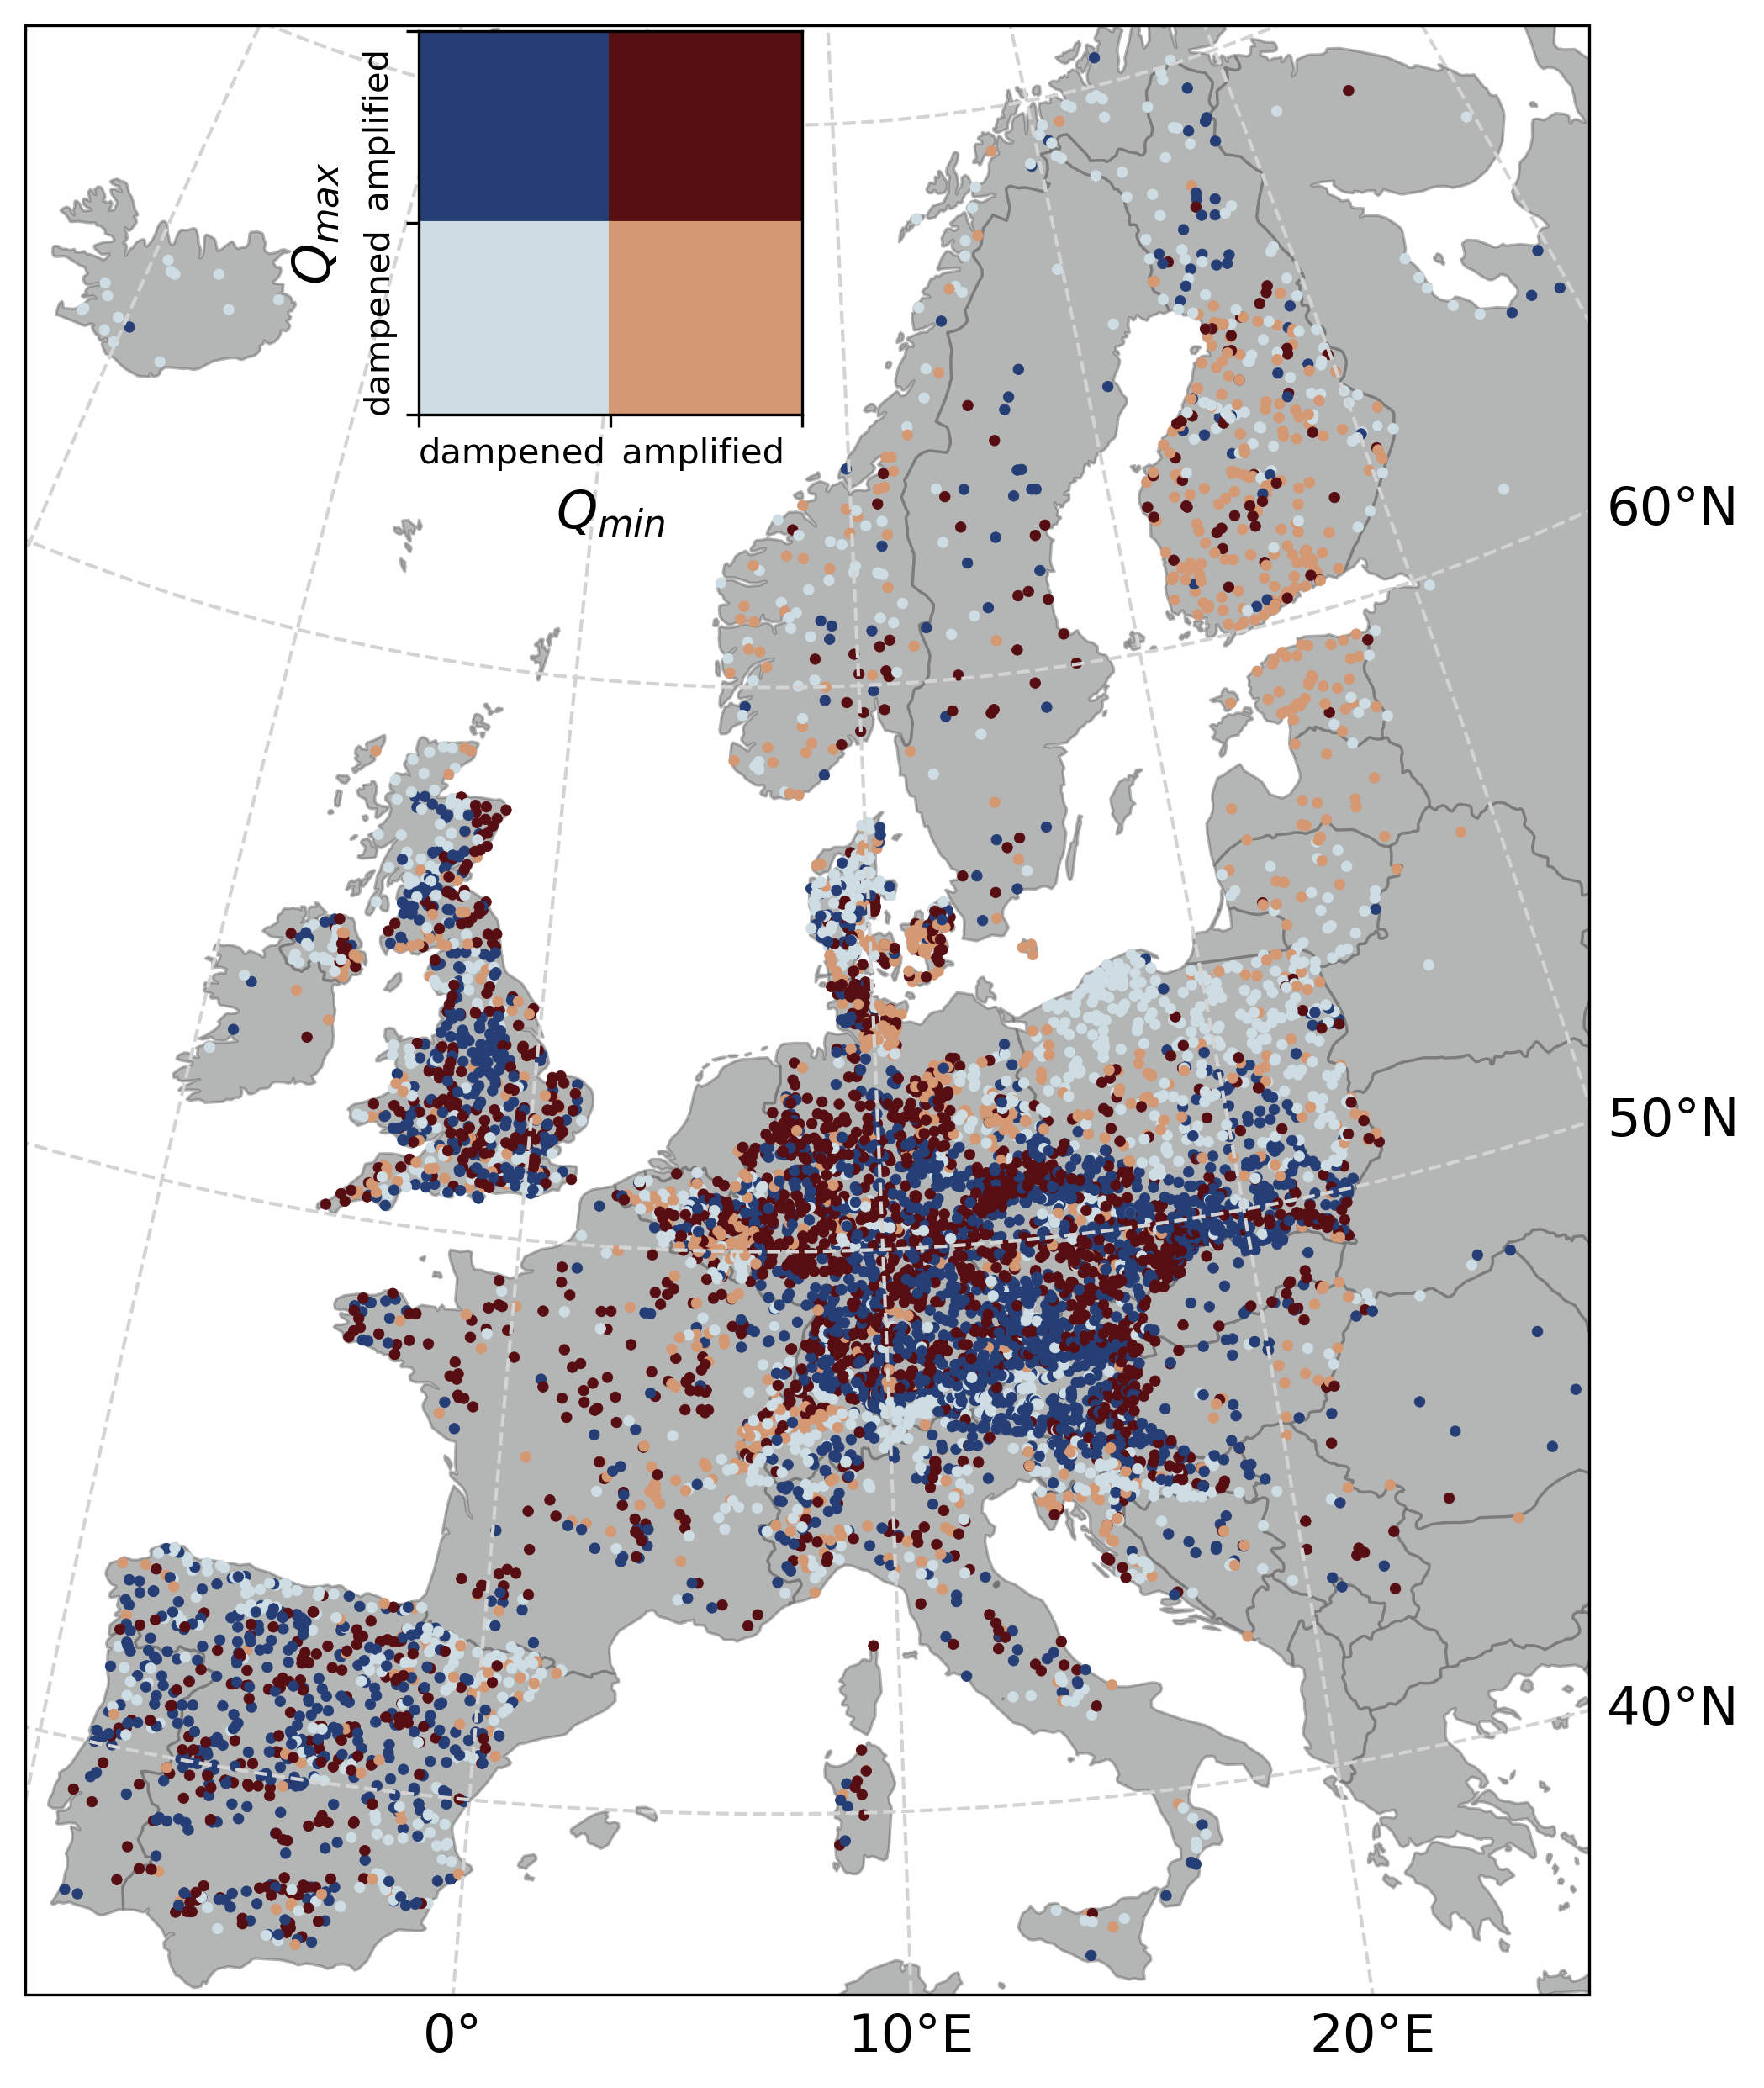

In [31]:
ft=15

# Create figure and GeoAxes with projection
fig, ax = plt.subplots(figsize=(8, 12), subplot_kw={'projection': prj_lambert}, dpi=300) #12*(width_proj/height_proj)
fig.patch.set_alpha(0)
ax.set_extent(europe_extent, crs=extent_crs)  # the projection the data is in
#ax.set_aspect('auto')
ax.set_facecolor('white')

# Gridlines
gl = ax.gridlines(extent_crs,#crs=ccrs.PlateCarree(),
                  draw_labels=True, linewidth=1, color='lightgray', linestyle='--')
# Set major gridlines at 10-degree intervals for both longitude and latitude
gl.xlocator = ticker.MultipleLocator(10)  # Longitude gridlines every 10 degrees
gl.ylocator = ticker.MultipleLocator(10)  # Latitude gridlines every 10 degrees
gl.top_labels = gl.left_labels = False
gl.bottom_labels = True
gl.right_labels = True
gl.xlabel_style = {'size': ft, 'color': 'k'}
gl.ylabel_style = {'size': ft, 'color': 'k'}

europe.boundary.plot(ax=ax, transform=extent_crs, #prj_lambert, #ccrs.PlateCarree(),
                             edgecolor='dimgrey',
                             facecolor='#6B6C6D', 
                             alpha=0.5,
                             linewidth=0.8, zorder=1)

valid_data.plot(ax=ax, color=colors, edgecolor=colors, linewidth=0.2, markersize=9)

# Custom legend (discrete bivariate)
legend_ax = fig.add_axes([0.32, 0.66, 0.19, 0.19])  # Position
legend_ax.set_aspect('equal')

legend_ax.add_patch(mpatches.Rectangle((0, 1), 1, 1, color=color_tl))  # Top-left
legend_ax.add_patch(mpatches.Rectangle((1, 1), 1, 1, color=color_tr))  # Top-right
legend_ax.add_patch(mpatches.Rectangle((0, 0), 1, 1, color=color_bl))  # Bottom-left
legend_ax.add_patch(mpatches.Rectangle((1, 0), 1, 1, color=color_br))  # Bottom-right

legend_ax.set_xlim(0, 2)
legend_ax.set_ylim(0, 2)
legend_ax.set_xticks([0, 1, 2])
legend_ax.set_yticks([0, 1, 2])
legend_ax.set_xticklabels(['dampened', ' amplified', ''])
legend_ax.set_yticklabels(['dampened', ' amplified', ''], rotation=90)

legend_ax.set_xlabel("$Q_{min}$", fontsize=ft, labelpad=5)
legend_ax.set_ylabel("$Q_{max}$", fontsize=ft, labelpad=6)
[label.set_va('bottom') for label in legend_ax.get_yticklabels()]
[label.set_ha('left') for label in legend_ax.get_xticklabels()]
legend_ax.tick_params(axis='both', labelsize=ft-5, pad=3)

#plt.tight_layout()
plt.savefig(fp_figures/f"03_sensitivities/01_hyearly/maps/A-OCT_combi_QmaxQmin-Pelas_class.png", dpi=300, bbox_inches='tight')
plt.savefig(fp_figures/f"03_sensitivities/01_hyearly/maps/A-OCT_combi_QmaxQmin-Pelas_class.pdf", bbox_inches='tight')
plt.show()